In [75]:
#pip install --upgrade MetaTrader5
#pip install yfinance

  You can safely remove it manually.


  Attempting uninstall: MetaTrader5
    Found existing installation: metatrader5 5.0.5388
    Uninstalling metatrader5-5.0.5388:
      Successfully uninstalled metatrader5-5.0.5388
Note: you may need to restart the kernel to use updated packages.


In [1]:
# ================================================
# Cell 1 NOTEBOOK 3 — LIVE TRADING ENGINE
# ================================================
import os, glob, time, json
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
import gymnasium as gym
from typing import Dict, List, Optional
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
# ================================================
# Cell 2 - Paths (update if needed)
# ================================================
DATA_DIR = os.path.join("data", "multiasset")
MODEL_DIR = os.path.join("models", "multiasset")
EMBED_FILE = os.path.join(MODEL_DIR, "asset_embeddings.npy")
ASSET_MAP_FILE = os.path.join(DATA_DIR, "asset_to_idx.csv")
MODEL_FILE = os.path.join(MODEL_DIR, "ppo_multiasset.zip")
VEC_FILE = os.path.join(MODEL_DIR, "vec_normalize.pkl")
LOG_DIR = os.path.join(MODEL_DIR, "live_logs")
os.makedirs(LOG_DIR, exist_ok=True)
LOG_FILE = os.path.join(LOG_DIR, "live_trade_logs.csv")

In [3]:
# ================================================
# Cell 3 - Configuration
# ================================================
DRY_RUN = False            # SET True for tests. Set False only after demo tests.
WINDOW = 50 # Minimum required lookback window for analysis (e.g., for indicators)
BUFFER = 60
COUNT = WINDOW + BUFFER
DEFAULT_LOT = 1
MAX_POS_PER_SYMBOL = 1
DEFAULT_SL_PIPS_FALLBACK = 100
RRR = 3
TRAIL_PIPS_DEFAULT = 10
MAGIC = 2025001          # Unique identifier for trades
COMMENT = "Sleekster_AI_Bot"
DEVIATION = 20  
# NEW: Risk Management Configuration
RISK_PERCENTAGE = 0.02    # Risk 1% (0.02) of account balance per trade
ATR_PERIOD = 14
ATR_MULTIPLIER = 10.0      # Stop Loss is set at 2.0 * ATR value
ADJUST_SL = 1.5

SL_OFFSET_PIPS = 10000      # Stop Loss offset in pips
TP_OFFSET_PIPS = 20000      # Take Profit offset in pips
# List to collect all trade results
ALL_TRADE_RESULTS = []


In [4]:
# ================================================
# Cell 4 - Timeframe
# ================================================
TIMEFRAME = "M15"
TF_MAP = {"M1": mt5.TIMEFRAME_M1, "M5": mt5.TIMEFRAME_M5, "M15": mt5.TIMEFRAME_M15,
          "M30": mt5.TIMEFRAME_M30, "H1": mt5.TIMEFRAME_H1, "H4": mt5.TIMEFRAME_H4, "D1": mt5.TIMEFRAME_D1}
TF_MT5 = TF_MAP.get(TIMEFRAME.upper(), mt5.TIMEFRAME_M15)


In [5]:
# ================================================
# Cell 5 - MT5 connection
# ================================================
def mt5_connect() -> bool:
    try:
        if not mt5.initialize():
            # try again to get more helpful info
            err = mt5.last_error()
            print("mt5.initialize() first attempt returned False:", err)
            ok = mt5.initialize()
            if not ok:
                print("mt5.initialize() retry failed:", mt5.last_error())
                return False
        print("MT5 connected. Version:", mt5.version())
        return True
    except Exception as e:
        print("MT5 connection error:", e)
        return False

def mt5_shutdown():
    try:
        mt5.shutdown()
        # Print confirmation message upon successful execution of mt5.shutdown()
        print("Disconnected")
    except Exception:
        # Pass silently if shutdown fails
        pass

In [6]:
# ================================================
# Cell 6 - Symbols sellection
# ================================================
SYMBOLS: List[str] = [
    # Volatility Indices
    "Volatility 10 Index","Volatility 25 Index","Volatility 50 Index","Volatility 75 Index","Volatility 100 Index",
    "Volatility 10 (1s) Index","Volatility 25 (1s) Index","Volatility 50 (1s) Index","Volatility 75 (1s) Index","Volatility 100 (1s) Index",
    "Volatility 50 (1s) Index","Volatility 75 (1s) Index","Volatility 100 (1s) Index",
    # Jump and Step Indices
    "Jump 10 Index","Jump 25 Index","Jump 50 Index","Jump 75 Index","Jump 100 Index",
    "Step Index 25","Step Index 50","Step Index 75","Step Index 100",
    # Major Currency Pairs Added
    "EURUSD", "GBPUSD", "USDJPY", "AUDUSD", "USDCAD", "USDCHF", "NZDUSD", "EURGBP", "EURJPY"
]

In [7]:
# ================= Full Trade Execution ================= This can trade

# If broker uses different symbol names, map safe_name -> broker_symbol
MANUAL_SYMBOL_MAP: Dict[str, str] = {
    # example: "Volatility_75_Index": "DerivVol75"
    # add entries if MT5 symbol_info(name) would be None for the plain name
}

# ----------------- Helpers -----------------
def make_safe_name(sym: str) -> str:
    return sym.replace(" ", "_").replace("/", "_").replace("(", "").replace(")", "").replace(".", "_")

def get_mt5_symbol_from_safe(safe_name: str) -> str:
    return MANUAL_SYMBOL_MAP.get(safe_name, safe_name.replace("_", " "))

In [8]:
# ================================================
# Cell 7 - Load PPO model, VecNormalize, embeddings, scalers, datasets 
# ================================================
print("Loading model and preprocessors...")
if not os.path.exists(MODEL_FILE):
    raise FileNotFoundError("Model file missing: " + MODEL_FILE)
model = PPO.load(MODEL_FILE)
print("PPO model loaded:", MODEL_FILE)

# load embeddings (attempt different formats)
embeddings = {}
EMBED_DIM = 8
if os.path.exists(EMBED_FILE):
    try:
        emb_loaded = np.load(EMBED_FILE, allow_pickle=True)
        # if saved dict
        if isinstance(emb_loaded, np.ndarray) and emb_loaded.dtype == object:
            try:
                obj = emb_loaded.item()
                if isinstance(obj, dict):
                    embeddings = {k: np.array(v, dtype=np.float32) for k, v in obj.items()}
            except Exception:
                pass
        if len(embeddings) == 0:
            # if array mapping by index
            try:
                arr = np.array(emb_loaded)
                if arr.ndim == 2:
                    # attempt mapping with asset_to_idx
                    if os.path.exists(ASSET_MAP_FILE):
                        try:
                            am = pd.read_csv(ASSET_MAP_FILE, index_col=0, header=None).iloc[:,0].to_dict()
                            for safe, idx in am.items():
                                idx = int(idx)
                                if idx < arr.shape[0]:
                                    embeddings[safe] = np.array(arr[idx], dtype=np.float32)
                        except Exception:
                            pass
                # final fallback: if embeddings length matches input CSV count, map by CSV order in data dir
                if len(embeddings) == 0 and arr.ndim == 2:
                    csvs = sorted(glob.glob(os.path.join(DATA_DIR, "*_normalized.csv")))
                    safe_list = [os.path.basename(p).replace("_normalized.csv","") for p in csvs]
                    if len(safe_list) == arr.shape[0]:
                        for i, s in enumerate(safe_list):
                            embeddings[s] = np.array(arr[i], dtype=np.float32)
            except Exception:
                pass
    except Exception as e:
        print("Failed to load embeddings:", e)
if len(embeddings) > 0:
    EMBED_DIM = next(iter(embeddings.values())).shape[0]
print("Embeddings loaded:", len(embeddings), "embed_dim:", EMBED_DIM)


# VecNormalize (safe load using dummy env)
vecnorm = None
if os.path.exists(VEC_FILE):
    try:
        class _DummyEnv(gym.Env):
            def __init__(self):
                super().__init__()
                self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(WINDOW, 5 + 1 + EMBED_DIM), dtype=np.float32)
                self.action_space = gym.spaces.Discrete(3)
            def reset(self, seed=None, options=None):
                return np.zeros(self.observation_space.shape, dtype=np.float32), {}
            def step(self, action):
                return np.zeros(self.observation_space.shape, dtype=np.float32), 0.0, True, False, {}
        venv = DummyVecEnv([lambda: _DummyEnv()])
        vecnorm = VecNormalize.load(VEC_FILE, venv)
        vecnorm.training = False
        vecnorm.norm_reward = False
        print("VecNormalize loaded:", VEC_FILE)
    except Exception as e:
        print("VecNormalize load failed (continuing without it):", e)
        vecnorm = None
else:
    print("No VecNormalize file found; continuing without it.")


Loading model and preprocessors...
PPO model loaded: models\multiasset\ppo_multiasset.zip
Embeddings loaded: 17 embed_dim: 8
VecNormalize loaded: models\multiasset\vec_normalize.pkl


In [9]:
# ================================================
# Cell 7 - LOAD SCALERS 
# ================================================
# scalers
def load_scalers(data_dir=DATA_DIR):
    scalers = {}
    for p in sorted(glob.glob(os.path.join(data_dir, "*_scaler.csv"))):
        safe = os.path.basename(p).replace("_scaler.csv","")
        df = pd.read_csv(p, index_col=0)
        scalers[safe] = {"mean": df["mean"], "std": df["std"]}
    return scalers

scalers = load_scalers()
print("Scalers loaded:", len(scalers))

Scalers loaded: 16


In [10]:
# ================================================
# Cell 8 - datasets (prepared normalized CSVs)
# ================================================
def load_prepared_datasets(data_dir=DATA_DIR, window=WINDOW):
    datasets = {}
    for p in sorted(glob.glob(os.path.join(data_dir, "*_normalized.csv"))):
        safe = os.path.basename(p).replace("_normalized.csv","")
        df = pd.read_csv(p, index_col=0, parse_dates=True)
        expected = ['o_pc','h_pc','l_pc','c_pc','v_pc','Close_raw']
        if all(c in df.columns for c in expected):
            tmp = df[expected].dropna()
            if len(tmp) > window:
                datasets[safe] = tmp
        else:
            # try convert from OHLCV if possible
            if all(c in df.columns for c in ['open','high','low','close','volume']):
                tmp = pd.DataFrame(index=df.index)
                tmp['o_pc'] = df['open'].pct_change()
                tmp['h_pc'] = df['high'].pct_change()
                tmp['l_pc'] = df['low'].pct_change()
                tmp['c_pc'] = df['close'].pct_change()
                tmp['v_pc'] = df['volume'].pct_change()
                tmp['Close_raw'] = df['close']
                tmp = tmp.dropna()
                if len(tmp) > window:
                    datasets[safe] = tmp
    return datasets

datasets = load_prepared_datasets()
print("Prepared datasets loaded:", len(datasets))

Prepared datasets loaded: 16


In [11]:
# ================================================
# Cell 9 - Live bars fetch
# ================================================
def _fetch_single_symbol_bars(mt5_symbol: str, timeframe: int, count: int) -> Optional[pd.DataFrame]:
    info = mt5.symbol_info(mt5_symbol)
    if info is None:
        # no such symbol in terminal
        return None
    if not info.visible:
        try:
            mt5.symbol_select(mt5_symbol, True)
        except Exception:
            pass
    end_time = datetime.now()
    bars = mt5.copy_rates_from(mt5_symbol, timeframe, end_time, count)
    if bars is None or len(bars) < WINDOW + 2:
        return None
    df = pd.DataFrame(bars)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df = df.set_index('time')
    if 'tick_volume' in df.columns:
        df = df.rename(columns={'tick_volume':'volume'})
    df = df[['open','high','low','close','volume']].copy()
    df['Close_raw'] = df['close']
    return df

In [12]:
# ----------------- Observation builder -----------------
def build_obs_for_symbol(mt5_symbol: str, safe_name: str, window: int = WINDOW):
    # try live bars
    df_live = _fetch_single_symbol_bars(mt5_symbol, TF_MT5, COUNT)
    if df_live is None:
        # fallback to prepared dataset
        if safe_name not in datasets:
            return None, None, None
        df_pct = datasets[safe_name].iloc[-window:][['o_pc','h_pc','l_pc','c_pc','v_pc']]
        last_price = float(datasets[safe_name]['Close_raw'].iloc[-1])
        features = df_pct.values.astype(np.float32)
    else:
        # compute percent changes from live OHLCV
        df_pct = df_live[['open','high','low','close','volume']].pct_change().dropna()
        if len(df_pct) < window:
            return None, None, None
        df_pct = df_pct.tail(window)
        last_price = float(df_live['Close_raw'].iloc[-1])
        features = df_pct[['open','high','low','close','volume']].values.astype(np.float32)

    # scaler required
    if safe_name not in scalers:
        return None, None, None
    s = scalers[safe_name]
    mean = np.array(s['mean'].values if hasattr(s['mean'],'values') else s['mean'], dtype=np.float32)
    std = np.array(s['std'].values if hasattr(s['std'],'values') else s['std'], dtype=np.float32)
    std = np.where(std == 0, 1e-8, std)

    if features.shape[1] != len(mean):
        return None, None, None

    features_scaled = (features - mean) / std

    # embedding
    emb_vec = embeddings.get(safe_name, np.zeros(EMBED_DIM, dtype=np.float32))
    emb_block = np.repeat(emb_vec.reshape(1,-1), window, axis=0)

    # balance norm column (training used some balance column — here we set 1.0)
    balance_col = np.ones((window,1), dtype=np.float32)

    obs = np.concatenate([features_scaled.astype(np.float32), balance_col, emb_block], axis=1)

    # apply VecNormalize if available (best-effort)
    if vecnorm is not None:
        try:
            # prefer normalize_obs if available
            try:
                obs = vecnorm.normalize_obs(obs, False)
            except Exception:
                # fallback to obs_rms stats
                flat = obs.reshape(1,-1)
                mean_rms = getattr(vecnorm.obs_rms, "mean", None)
                var_rms = getattr(vecnorm.obs_rms, "var", None)
                if mean_rms is not None and var_rms is not None and len(mean_rms) == flat.shape[1]:
                    flat_norm = (flat - mean_rms) / np.sqrt(var_rms + 1e-8)
                    obs = flat_norm.reshape(obs.shape).astype(np.float32)
        except Exception:
            pass

    vol_est = float(np.std(features[:,3]))  # std of close pct
    return obs.astype(np.float32), vol_est, last_price


In [13]:
def avg_true_range(symbol: str, timeframe: int, num_of_bars: int) -> float:
    """
    Calculates the sum of True Ranges over historical bars and divides by the 
    number of bars, strictly following the provided MQL implementation.
    
    Note: The calculation includes (num_of_bars - 1) True Range values but divides 
    by num_of_bars, matching the original MQL code's formula.

    :param symbol: Trading instrument.
    :param timeframe: Timeframe (e.g., mt5.TIMEFRAME_D1).
    :param num_of_bars: Number of historical bars to analyze (starting from bar 1).
    :return: The calculated average True Range sum, or -1.0 on error.
    """
    mt5_connect()
    # 1. Data Retrieval: Fetch num_of_bars + 1 to ensure we have Bar 0's Close
    # which is needed to calculate the True Range of Bar 1 (the first bar in the MQL loop).
    rates_all = mt5.copy_rates_from_pos(symbol, timeframe, 0, num_of_bars + 1)
    
    if rates_all is None or len(rates_all) != num_of_bars + 1:
        print(f"Error: Failed to retrieve {num_of_bars + 1} bars for {symbol}.", file=sys.stderr)
        mt5_shutdown()
        return -1.0

    df_all = pd.DataFrame(rates_all)
    # Historical bars analyzed start from index 1 (Bar 1) up to num_of_bars.
    df_hist = df_all.iloc[1:num_of_bars + 1].copy()
    
    # 2. Calculate True Range (TR)
    
    # range1: High - Low
    range1 = df_hist['high'] - df_hist['low']
    # range2: Abs(High - Previous Close). The previous close is df_all.iloc[i-1]['close']
    range2 = abs(df_hist['high'] - df_all['close'].shift(1).iloc[1:num_of_bars + 1])
    # range3: Abs(Low - Previous Close)
    range3 = abs(df_hist['low'] - df_all['close'].shift(1).iloc[1:num_of_bars + 1])
    
    # True Range is the maximum of the three ranges
    df_hist['true_range'] = np.maximum.reduce([range1, range2, range3])
    
    # 3. Summation
    true_range_sum = df_hist['true_range'].sum()

    # 4. Final Average Calculation (Matching MQL logic: trueRangeSum / numOfBars)
    if num_of_bars == 0:
        avg_true_range_sum = 0.0
    else:
        avg_true_range_sum = true_range_sum / num_of_bars
    
    mt5_shutdown()
    
    # 5. Return Absolute Value (Matching MQL logic: MathAbs(avgTrueRangeSum))
    return abs(avg_true_range_sum)


In [14]:
def getDigits(symbol: str) -> int:
    """
    Retrieves the number of decimal digits after the decimal point of the price
    for a given symbol using the MetaTrader5 API.

    :param symbol: The instrument symbol (e.g., "EURUSD").
    :return: The number of decimal digits, or 0 if retrieval fails.
    """
    if not mt5_connect():
        return 0

    symbol_info = mt5.symbol_info(symbol)

    if symbol_info is None:
        print(f"Error: Could not retrieve symbol info for {symbol}. Error: {mt5.last_error()}", file=sys.stderr)
        mt5_shutdown()
        return 0
    
    digit = symbol_info.digits
        
    mt5_shutdown()
    return digit

In [15]:
def Compute_SL_TP (symbol: str, askPrice: float, direction, adjustSL: float):
    """
    direction = 1: BUY
    direction = 2: SELL (symbol: str, timeframe: int, num_of_bars: int, ADJUST_SL)
    """
    digits = getDigits(symbol)
    if direction == 1:
        SL = round(askPrice - (avg_true_range(symbol, TF_MT5, WINDOW) * ADJUST_SL), digits)
        riskInPoint = askPrice - SL
        TP = round(askPrice + (RRR * riskInPoint), digits)
    if direction == 2:       
        SL = round(askPrice + (avg_true_range(symbol, TF_MT5, WINDOW) * ADJUST_SL), digits)
        riskInPoint = SL - askPrice;
        TP = round(askPrice - (RRR * riskInPoint), digits)
    
    return float(SL), float(TP)


In [17]:
symbol = "EURUSD"
sll = Compute_SL_TP(symbol, 1.16386, 2, ADJUST_SL)
print("sll: ", sll)
stoploss = sll[0]
takeProfit =  sll[1]
print("stoploss: ", stoploss)
print("takeProfit: ", takeProfit)

MT5 connected. Version: (500, 5430, '14 Nov 2025')
Disconnected
MT5 connected. Version: (500, 5430, '14 Nov 2025')
Disconnected
sll:  (1.16458, 1.1617)
stoploss:  1.16458
takeProfit:  1.1617


In [18]:
# Calculate Optimum Lot-size
def calculate_optimal_volume(symbol: str, entry_price: float, sl_price: float) -> float:
    """
    Calculates the optimal lot size based on account equity, risk percentage,
    and the stop loss distance, constrained by symbol limits.

    The formula is: OptimalLotSize = (Equity * RiskPercentage) / (abs(EntryPrice - SLPrice) * ContractSize)
    """
    mt5_connect()
    # 1. Get Account Equity
    account_info = mt5.account_info()
    if account_info is None:
        print("Error: Could not retrieve account information.")
        return 0.0
    acc_balance = account_info.balance
    
    # 2. Get Symbol Information for contract size and volume limits
    symbol_info = mt5.symbol_info(symbol)
    if symbol_info is None:
        print(f"Error: Could not retrieve symbol info for {symbol}.")
        return 0.0
    
    contract_size = symbol_info.trade_contract_size
    min_volume = symbol_info.volume_min
    max_volume = symbol_info.volume_max
    volume_step = symbol_info.volume_step
    
    # Check for zero values to prevent division by zero
    if contract_size == 0:
        print(f"Error: Contract size is zero for {symbol}. Returning minimum volume.")
        return min_volume
        
    # 3. Calculate Maximum Dollar Loss
    max_loss_dollar = acc_balance * RISK_PERCENTAGE
    
    # 4. Calculate Loss per Lot (Loss in price difference * Contract Size)
    price_loss = abs(entry_price - sl_price)
    
    # If SL is too close or equal to entry, use min volume as a fallback.
    if price_loss == 0.0:
        print(f"Warning: SL is equal to entry price for {symbol}. Using minimum volume.")
        return min_volume

    loss_per_lot = price_loss * contract_size
    
    # 5. Calculate Optimal Lot Size (Theoretical)
    optimal_lot_size = max_loss_dollar / loss_per_lot
    
    # 6. Apply Volume Step and Min/Max constraints
    
    # Snap the calculated lot size to the nearest allowed volume step (e.g., 0.01)
    optimal_lot_size = round(optimal_lot_size / volume_step) * volume_step
    
    # Apply min/max volume limits
    final_volume = max(min_volume, min(max_volume, optimal_lot_size))
        
    print(f"  [Risk Calcs] Balance: {acc_balance:.2f}, Risk: {RISK_PERCENTAGE * 100}%, Max Loss $: {max_loss_dollar:.2f}, Final Volume: {final_volume:.2f}")
    
    # Ensure the final volume is rounded to the step size's precision
    final_volume = round(final_volume, len(str(volume_step).split('.')[-1]) if '.' in str(volume_step) else 0)

    mt5_shutdown()
    return final_volume


In [33]:
#symbol = "EURUSD"
#symbol = "Volatility 50 (1s) Index"
symbol = "Volatility 50 Index"
info = mt5.symbol_info(symbol)

print("Bid:", info.bid)
print("Ask:", info.ask)
print("Digits:", info.digits) # Number of digits after the decimal point of price
print("Contract Size:", info.trade_contract_size)
print("Volume Min:", info.volume_min)
print("Trade tick size:", info.trade_tick_size)
print("Trade tick value:", info.trade_tick_value)
#print("Volume Step:", info.volume_step)
print("Point:", info.point)

Bid: 143.2208
Ask: 143.2398
Digits: 4
Contract Size: 1.0
Volume Min: 4.0
Trade tick size: 0.0001
Trade tick value: 0.0001
Point: 0.0001


In [25]:
#symbol = "EURUSD"
#symbol = "Volatility 50 (1s) Index"
symbol = "Volatility 50 Index"
info = mt5.symbol_info(symbol)

print("Bid:", info.bid)
print("Ask:", info.ask)
print("Digits:", info.digits) # Number of digits after the decimal point of price
print("Contract Size:", info.trade_contract_size)
print("Volume Min:", info.volume_min)
print("Trade tick size:", info.trade_tick_size)
print("Trade tick value:", info.trade_tick_value)
#print("Volume Step:", info.volume_step)
print("Point:", info.point)


Bid: 143.7173
Ask: 143.7363
Digits: 4
Contract Size: 1.0
Volume Min: 4.0
Trade tick size: 0.0001
Trade tick value: 0.0001
Point: 0.0001


In [19]:
def place_market_order(symbol: str, direction: str, sl_price: float, tp_price: float):

    # Get current price
    tick = mt5.symbol_info_tick(symbol)
    if tick is None:
        print(f"Failed to get current tick for {symbol}.")
        # Return a dictionary indicating local failure before calling format_result
        return None, {"symbol": symbol, "type": direction, "volume": 0.0} 

    tick = mt5.symbol_info_tick(symbol)
    if tick is None:
        return {"retcode": None, "comment": "NO_TICK"}
    price = float(tick.ask if direction == "BUY" else tick.bid)
    if DRY_RUN:
        return {"retcode": 10009, "comment": "DRY_RUN", "price": price}

    lot = calculate_optimal_volume(symbol, price, sl_price, RISK_PERCENTAGE)
    
    if lot <= 0.0005:
        print(f"Skipping trade for {broker_sym}: Calculated volume is zero or negative.")
        # Return the request dictionary with 0 volume to be logged as a skipped trade
        return None, {"symbol": broker_sym, "type": direction, "volume": 0.0}
    
    req = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": float(lot),
        "type": mt5.ORDER_TYPE_BUY if direction=="BUY" else mt5.ORDER_TYPE_SELL,
        "price": price,
        "sl": float(sl_price) if sl_price is not None else 0.0,
        "tp": float(tp_price) if tp_price is not None else 0.0,
        #"sl": round(sl_price, symbol_info.digits), 
        #"tp": round(tp_price, symbol_info.digits),
        "deviation": DEVIATION,
        "magic": MAGIC,
        "comment": "ppo_multiasset_live",
        "type_filling": mt5.ORDER_FILLING_FOK,
    }
    
    return mt5.order_send(req)

In [19]:
# ================================================
# Cell 1 SEND LIVE MARKET ODER -BEST-
# ================================================
def place_market_order(symbol_info, order_type: int, lot: float, stopLoss:float, takeProfit:float): 
    """
    Constructs and sends a market order (BUY or SELL) using a dynamically calculated volume.
    
    :param symbol_info: mt5.symbol_info object
    :param pip_value: The size of a single pip (point) for the symbol
    :param order_type: mt5.ORDER_TYPE_BUY or mt5.ORDER_TYPE_SELL
    """
    pip_value = 0.3
    symbol = symbol_info.name
    
    # Get current price
    tick = mt5.symbol_info_tick(symbol)
    if tick is None:
        print(f"Failed to get current tick for {symbol}.")
        # Return a dictionary indicating local failure before calling format_result
        #return None, {"symbol": symbol, "type": order_type, "volume": 0.0} 

    # Determine execution price, trade type, and SL/TP prices
    if order_type == mt5.ORDER_TYPE_BUY:
        price = tick.ask
        type_text = "BUY"
        # SL/TP calculation (SL below, TP above entry price for BUY)
        sl_price = price - (SL_OFFSET_PIPS * pip_value)
        tp_price = price + (TP_OFFSET_PIPS * pip_value)
    elif order_type == mt5.ORDER_TYPE_SELL:
        price = tick.bid
        type_text = "SELL"
        # SL/TP calculation (SL above, TP below entry price for SELL)
        sl_price = price + (SL_OFFSET_PIPS * pip_value)
        tp_price = price - (TP_OFFSET_PIPS * pip_value)
    else:
        print("Invalid order type.")
        return None, None
        
    # --- DYNAMIC VOLUME CALCULATION ---
    volume_to_use = calculate_optimal_volume(
        symbol, 
        price, 
        sl_price, 
        RISK_PERCENTAGE
    )
    
    if volume_to_use <= 0.0:
        print(f"Skipping trade for {symbol}: Calculated volume is zero or negative.")
        # Return the request dictionary with 0 volume to be logged as a skipped trade
        return None, {"symbol": symbol, "type": order_type, "volume": 0.0}

    # Prepare the request dictionary
    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": volume_to_use, # <-- Dynamic volume used here
        "type": order_type,
        "price": price,
        # Round SL/TP based on the symbol's number of digits
        "sl": round(sl_price, symbol_info.digits), 
        "tp": round(tp_price, symbol_info.digits), 
        "deviation": DEVIATION,
        "magic": MAGIC,
        "comment": COMMENT,
        "type_time": mt5.ORDER_TIME_GTC, 
        "type_filling": mt5.ORDER_FILLING_FOK, 
    }

    # Send order to MT5
    print(f"  Sending {type_text} order for {symbol} with {volume_to_use:.2f} lots at {price:.{symbol_info.digits}f}...")
    result = mt5.order_send(request)

    return result, request



In [22]:
def close_position_by_ticket(ticket: int):
    pos_list = mt5.positions_get(ticket=ticket)
    if not pos_list:
        return None
    p = pos_list[0]
    symbol = p.symbol
    if getattr(p,"type",None) == 0:  # BUY
        order_type = mt5.ORDER_TYPE_SELL
        price = mt5.symbol_info_tick(symbol).bid
    else:
        order_type = mt5.ORDER_TYPE_BUY
        price = mt5.symbol_info_tick(symbol).ask
    if DRY_RUN:
        return {"retcode":10009, "comment":"DRY_RUN_CLOSE", "ticket": ticket}
    req = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": float(p.volume),
        "type": order_type,
        "position": int(ticket),
        "price": price,
        "deviation": 20,
        "magic": 234000,
        "comment": "auto_close",
    }
    return mt5.order_send(req)


In [21]:
# ----------------- Main run loop: single pass -----------------
def run_once_predict_and_manage(symbols_list: List[str]):
    if not mt5_connect():
        print("MT5 connect failed — aborting.")
        return

    acct = mt5.account_info()
    balance = float(acct.balance) if acct is not None else 10000.0
    header = not os.path.exists(LOG_FILE)

    for raw_sym in symbols_list:
        safe_name = make_safe_name(raw_sym)
        broker_sym = get_mt5_symbol_from_safe(safe_name)
        print(f"\n=== {broker_sym} (safe: {safe_name}) ===")

        obs_tuple = build_obs_for_symbol(broker_sym, safe_name, WINDOW)
        if obs_tuple is None:
            print("No observation for", safe_name, "- skipping")
            continue
        obs, vol, last_price = obs_tuple

        # predict
        try:
            action, _ = model.predict(obs[np.newaxis, ...], deterministic=True)
            a = int(action[0]) if isinstance(action, (list, tuple, np.ndarray)) else int(action)
        except Exception as e:
            print("Prediction error:", e)
            continue

        print("Signal:", a, "(0=HOLD,1=BUY,2=SELL)")

        # manage positions
        positions = get_positions_for_symbol(broker_sym)
        print("Existing positions:", len(positions))

        # auto-close opposing positions
        if a == 1:  # BUY signal -> close SELL positions
            for p in positions:
                if getattr(p, "type", None) == 1:
                    print("Closing opposing SELL ticket", p.ticket)
                    close_position_by_ticket(p.ticket)
        elif a == 2:  # SELL signal -> close BUY positions
            for p in positions:
                if getattr(p, "type", None) == 0:
                    print("Closing opposing BUY ticket", p.ticket)
                    close_position_by_ticket(p.ticket)

        # refresh
        positions = get_positions_for_symbol(broker_sym)
        if len(positions) >= MAX_POS_PER_SYMBOL:
            print("Max positions reached for", broker_sym, "- skipping open")
        else:
            if a == 0:
                print("HOLD")
            else:
                direction = "BUY" if a == 1 else "SELL"
                #res = place_market_order(broker_sym, direction, 2, sl_price, tp_price)
                #res = place_market_order(broker_sym, direction, sl_price, tp_price)
                SL_TP = Compute_SL_TP(broker_sym, price, direction, ADJUST_SL)
                SL = SL_TP[0]
                TP = SL_TP[1]
                # --- DYNAMIC VOLUME CALCULATION ---
                lot = calculate_optimal_volume(broker_sym, price, SL, RISK_PERCENTAGE)
                    
                #res = place_market_order(broker_sym, direction, 0, 0)
                res = place_market_order(broker_sym, direction, SL, TP)
                if isinstance(res, dict):
                    retcode = res.get("retcode")
                    comment = res.get("comment")
                    exec_price = res.get("price", last_price)
                else:
                    retcode = getattr(res, "retcode", None)
                    comment = getattr(res, "comment", "")
                    exec_price = last_price

                entry = {
                    "timestamp": datetime.utcnow().isoformat(),
                    "safe": safe_name,
                    "symbol": broker_sym,
                    "action": direction,
                    "lot": 1,
                    "exec_price": exec_price,
                    "sl_price": sl_price,
                    "tp_price": tp_price,
                    "sl_pips": sl_pips,
                    "tp_pips": tp_pips,
                    "retcode": retcode,
                    "comment": comment,
                    "dry_run": DRY_RUN
                }
                pd.DataFrame([entry]).to_csv(LOG_FILE, mode="a", index=False, header=header)
                header = False
                #print("Placed", direction, "lot", lot, "retcode", retcode)
                print("Placed", direction, "lot", 1, "retcode", retcode)

        # trailing SL pass for current positions
        for p in get_positions_for_symbol(broker_sym):
            trail_pips = max(5, int(estimate_sl_pips(broker_sym, last_price, vol) // 2))
            pip = pip_value(broker_sym)
            if getattr(p, "type", None) == 0:  # BUY
                cur_price = mt5.symbol_info_tick(broker_sym).bid
                new_sl = float(cur_price - trail_pips * pip)
            else:
                cur_price = mt5.symbol_info_tick(broker_sym).ask
                new_sl = float(cur_price + trail_pips * pip)

            if DRY_RUN:
                print(f"[DRY] Would set trailing SL for ticket {p.ticket} -> {new_sl}")
            else:
                try:
                    req = {"action": mt5.TRADE_ACTION_SLTP, "symbol": broker_sym, "position": int(p.ticket), "sl": new_sl, "tp": float(p.tp) if getattr(p,"tp",None) else 0.0}
                    r = mt5.order_send(req)
                    print("Modify SL retcode:", getattr(r, "retcode", None))
                except Exception as e:
                    print("Modify SL failed:", e)

    mt5_shutdown()
    print("\nSingle pass complete. Logs written to:", LOG_FILE)

# ------------- run once (example) -------------
# For safety, you can test a subset:
test_symbols = SYMBOLS[:]  # change as needed
run_once_predict_and_manage(test_symbols)

# ------------- Optional continuous loop -------------
# Uncomment and use with caution (ensure DRY_RUN=False only after demo verification)
try:
    while True:
        run_once_predict_and_manage(SYMBOLS)
        time.sleep(60)   # run each minute for M1/M15 choose appropriate sleep
except KeyboardInterrupt:
    print("Stopped by user.")


MT5 connected. Version: (500, 5430, '14 Nov 2025')

=== Volatility 10 Index (safe: Volatility_10_Index) ===
Signal: 1 (0=HOLD,1=BUY,2=SELL)


NameError: name 'get_positions_for_symbol' is not defined

In [26]:
import MetaTrader5 as mt5
import pandas as pd
import time
from datetime import datetime
from typing import List
import numpy as np

# --- Configuration ---
# List of symbols to trade
SYMBOL_LIST: List[str] = [
    # Volatility Indices
    "Volatility 10 Index","Volatility 25 Index","Volatility 50 Index","Volatility 75 Index","Volatility 100 Index",
    "Volatility 10 (1s) Index","Volatility 25 (1s) Index","Volatility 50 (1s) Index","Volatility 75 (1s) Index","Volatility 100 (1s) Index",
    "Volatility 10 (10s) Index","Volatility 25 (10s) Index","Volatility 50 (10s) Index","Volatility 75 (10s) Index","Volatility 100 (10s) Index",
    # Jump and Step Indices
    "Jump 10 Index","Jump 25 Index","Jump 50 Index","Jump 75 Index","Jump 100 Index",
    "Step Index 25","Step Index 50","Step Index 75","Step Index 100",
    # Major Currency Pairs Added
    "EURUSD", "GBPUSD", "USDJPY", "AUDUSD", "USDCAD", "USDCHF", "NZDUSD", "EURGBP", "EURJPY"
]
DEVIATION = 10            # Maximum acceptable price deviation
MAGIC = 20250615          # Unique identifier for trades
COMMENT = "Multi_Symbol_Trade_Bot"
# SL_OFFSET_PIPS has been replaced by ATR-based settings:
TP_OFFSET_PIPS = 200      # Fixed Take Profit offset in pips (used if ATR is zero/fails)

# NEW: Risk Management & Volatility Configuration
RISK_PERCENTAGE = 0.01    # Risk 1% (0.01) of account equity per trade
ATR_PERIOD = 14           # Number of bars for ATR calculation (e.g., 14)
ATR_MULTIPLIER = 2.0      # Stop Loss is set at 2.0 * ATR value

# List to collect all trade results
ALL_TRADE_RESULTS = []

def connect_mt5(login=None, password=None, server=None) -> bool:
    """Initializes and connects to the MT5 terminal."""
    if not mt5.initialize():
        print(f"MT5 initialization failed. Error code: {mt5.last_error()}")
        return False

    if login and password and server:
        # Try to log in if credentials are provided
        authorized = mt5.login(login, password=password, server=server)
        if not authorized:
            print(f"Login failed: {mt5.last_error()}")
            mt5.shutdown()
            return False
            
    print(f"Successfully connected to MT5 terminal.")
    account_info = mt5.account_info()
    if account_info:
        print(f"Account: {account_info.login}")
    return True

def get_symbol_info(symbol: str):
    """
    Retrieves and prepares the symbol for trading.
    Returns the symbol information object and the price tick value.
    """
    symbol_info = mt5.symbol_info(symbol)
    if symbol_info is None:
        print(f"--- {symbol} NOT FOUND ---")
        return None, None

    if not symbol_info.visible:
        # Check if the symbol can be added to Market Watch
        if not mt5.symbol_select(symbol, True):
            print(f"--- {symbol} NOT TRADABLE: Not visible and could not be added ---")
            return None, None

    # Get the tick size (point value) for SL/TP calculations
    pip_value = symbol_info.point
    
    tick = mt5.symbol_info_tick(symbol)
    if tick is None:
        print(f"--- {symbol} NOT TRADABLE: Could not get tick info ---")
        return None, None
        
    print(f"\n--- Symbol Ready: {symbol} ---")
    print(f"Digits: {symbol_info.digits} | Point: {symbol_info.point} | Bid: {tick.bid} | Ask: {tick.ask}")
    
    return symbol_info, pip_value


def calculate_atr(symbol: str, timeframe: int, period: int) -> float:
    """
    Calculates the Simple Average True Range (SATR) over the specified period.
    MQL5 logic: ATR = AvgTrueRangeSum = Sum(TR) / period
    
    :param symbol: Trading instrument
    :param timeframe: Timeframe for historical data (e.g., mt5.TIMEFRAME_M1)
    :param period: Number of bars (N) for the calculation
    :return: ATR value (price movement)
    """
    # Request N+1 bars to ensure we have the necessary previous close price (C_n-1)
    rates = mt5.copy_rates_from_pos(symbol, timeframe, 1, period + 1)
    
    if rates is None or len(rates) < period + 1:
        print(f"  [ATR Error] Failed to get enough historical data for {symbol}.")
        return 0.0

    rates_df = pd.DataFrame(rates)
    
    # Calculate True Range (TR) for N bars (indices 0 to N-1)
    # 1. High - Low
    range1 = rates_df['high'] - rates_df['low']
    
    # 2. Abs(High - Previous Close)
    # Note: Shift(1) moves prices down, so rates_df['close'].shift(1) gives the *next older* bar's close.
    # We want the close of the bar *immediately following* the current one in the array (older in time).
    # Since we fetched bars from the past: rates_df[0] is newest, rates_df[period] is oldest.
    # We need the previous bar's close (C_n-1) which is at index i+1 for bar i.
    previous_close = rates_df['close'].shift(-1)
    range2 = abs(rates_df['high'] - previous_close)
    
    # 3. Abs(Low - Previous Close)
    range3 = abs(rates_df['low'] - previous_close)
    
    # Combine ranges (max of the three for each bar)
    # We only need TR for the most recent 'period' bars (indices 0 to period-1)
    tr = pd.concat([range1, range2, range3], axis=1).max(axis=1)
    
    # Calculate the Simple Average True Range (SATR) over the 'period' bars (excluding the last row/oldest bar which has NaN TR)
    atr_value = tr.iloc[0:period].mean()

    # If the calculation fails (e.g., first few bars of history), return 0.0
    if pd.isna(atr_value):
        print("  [ATR Error] ATR calculation resulted in NaN.")
        return 0.0
        
    print(f"  [ATR Calcs] ATR({period}) value: {atr_value:.8f}")
    
    return atr_value


def calculate_optimal_volume(symbol: str, entry_price: float, sl_price: float, risk_percent: float) -> float:
    """
    Calculates the optimal lot size based on account equity, risk percentage,
    and the stop loss distance, constrained by symbol limits.

    The formula is: OptimalLotSize = (Equity * RiskPercentage) / (abs(EntryPrice - SLPrice) * ContractSize)
    """
    
    # 1. Get Account Equity
    account_info = mt5.account_info()
    if account_info is None:
        print("Error: Could not retrieve account information.")
        return 0.0
    acc_equity = account_info.equity
    
    # 2. Get Symbol Information for contract size and volume limits
    symbol_info = mt5.symbol_info(symbol)
    if symbol_info is None:
        print(f"Error: Could not retrieve symbol info for {symbol}.")
        return 0.0
    
    contract_size = symbol_info.trade_contract_size
    min_volume = symbol_info.volume_min
    max_volume = symbol_info.volume_max
    volume_step = symbol_info.volume_step
    
    # Check for zero values to prevent division by zero
    if contract_size == 0:
        print(f"Error: Contract size is zero for {symbol}. Returning minimum volume.")
        return min_volume
        
    # 3. Calculate Maximum Dollar Loss
    max_loss_dollar = acc_equity * risk_percent
    
    # 4. Calculate Loss per Lot (Loss in price difference * Contract Size)
    price_loss = abs(entry_price - sl_price)
    
    # If SL is too close or equal to entry, use min volume as a fallback.
    if price_loss == 0.0:
        print(f"Warning: SL is equal to entry price for {symbol}. Using minimum volume.")
        return min_volume

    loss_per_lot = price_loss * contract_size
    
    # 5. Calculate Optimal Lot Size (Theoretical)
    optimal_lot_size = max_loss_dollar / loss_per_lot
    
    # 6. Apply Volume Step and Min/Max constraints
    
    # Snap the calculated lot size to the nearest allowed volume step (e.g., 0.01)
    optimal_lot_size = round(optimal_lot_size / volume_step) * volume_step
    
    # Apply min/max volume limits
    final_volume = max(min_volume, min(max_volume, optimal_lot_size))
        
    print(f"  [Risk Calcs] Equity: {acc_equity:.2f}, Risk %: {risk_percent*100}%, Max Loss $: {max_loss_dollar:.2f}, Final Volume: {final_volume:.2f}")
    
    # Ensure the final volume is rounded to the step size's precision
    final_volume = round(final_volume, len(str(volume_step).split('.')[-1]) if '.' in str(volume_step) else 0)

    return final_volume


def place_market_order(symbol_info, pip_value: float, order_type: int):
    """
    Constructs and sends a market order (BUY or SELL) using a dynamically calculated volume and ATR-based SL.
    
    :param symbol_info: mt5.symbol_info object
    :param pip_value: The size of a single pip (point) for the symbol
    :param order_type: mt5.ORDER_TYPE_BUY or mt5.ORDER_TYPE_SELL
    """
    symbol = symbol_info.name
    
    # Get current price
    tick = mt5.symbol_info_tick(symbol)
    if tick is None:
        print(f"Failed to get current tick for {symbol}.")
        # Return a dictionary indicating local failure before calling format_result
        return None, {"symbol": symbol, "type": order_type, "volume": 0.0} 

    # --- 1. DETERMINE ENTRY, SL, AND TP PRICES ---
    
    # Calculate ATR value (price distance)
    atr_price_distance = calculate_atr(symbol, mt5.TIMEFRAME_M1, ATR_PERIOD)
    
    # Use ATR * Multiplier for the SL distance. If ATR fails, use a fallback distance based on TP PIPS offset.
    if atr_price_distance > 0.0:
        sl_distance = atr_price_distance * ATR_MULTIPLIER
        print(f"  [SL Setup] Using ATR-based SL distance: {sl_distance:.{symbol_info.digits}f}")
    else:
        # Fallback to the fixed PIPS offset, converted to a price value
        sl_distance = TP_OFFSET_PIPS * pip_value
        print(f"  [SL Setup] ATR failed. Using fixed SL distance: {sl_distance:.{symbol_info.digits}f}")


    if order_type == mt5.ORDER_TYPE_BUY:
        price = tick.ask
        type_text = "BUY"
        # SL below entry price, TP above entry price
        sl_price = price - sl_distance
        tp_price = price + (TP_OFFSET_PIPS * pip_value) # Keep TP fixed for simplicity
    elif order_type == mt5.ORDER_TYPE_SELL:
        price = tick.bid
        type_text = "SELL"
        # SL above entry price, TP below entry price
        sl_price = price + sl_distance
        tp_price = price - (TP_OFFSET_PIPS * pip_value) # Keep TP fixed for simplicity
    else:
        print("Invalid order type.")
        return None, None
        
    # --- 2. DYNAMIC VOLUME CALCULATION ---
    volume_to_use = calculate_optimal_volume(
        symbol, 
        price, 
        sl_price, 
        RISK_PERCENTAGE
    )
    
    if volume_to_use <= 0.0:
        print(f"Skipping trade for {symbol}: Calculated volume is zero or negative.")
        # Return the request dictionary with 0 volume to be logged as a skipped trade
        return None, {"symbol": symbol, "type": order_type, "volume": 0.0}

    # --- 3. PREPARE AND SEND REQUEST ---
    # Prepare the request dictionary
    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": volume_to_use, # <-- Dynamic volume used here
        "type": order_type,
        "price": price,
        # Round SL/TP based on the symbol's number of digits
        "sl": round(sl_price, symbol_info.digits), 
        "tp": round(tp_price, symbol_info.digits), 
        "deviation": DEVIATION,
        "magic": MAGIC,
        "comment": COMMENT,
        "type_time": mt5.ORDER_TIME_GTC, 
        "type_filling": mt5.ORDER_FILLING_FOK, 
    }

    # Send order to MT5
    print(f"  Sending {type_text} order for {symbol} with {volume_to_use:.2f} lots at {price:.{symbol_info.digits}f}...")
    result = mt5.order_send(request)

    return result, request


def format_result(result, request):
    """
    Formats the order result and request into a clean dictionary.
    Handles both successful and failed execution attempts.
    """
    symbol = request.get("symbol", "N/A")
    symbol_info = mt5.symbol_info(symbol) if symbol != "N/A" else None
    digits = symbol_info.digits if symbol_info else 4 # Default to 4 digits for formatting
    
    # --- Local Failure Handling (e.g., failed tick check in place_market_order) ---
    if result is None:
        comment_text = request.get("comment", "Local error: Tick or price info failed.")
        if request.get("volume") == 0.0:
            comment_text = "Trade skipped: Volume calculated as zero."
            
        return {
            "Time": datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'),
            "Status": "SKIPPED/FAILED (Local)",
            "Return Code": "N/A",
            "Comment": comment_text,
            "Symbol": symbol,
            "Type": "BUY" if request.get("type") == mt5.ORDER_TYPE_BUY else "SELL",
            "Volume": request.get("volume", "N/A"),
            "Price": "N/A",
            "SL": "N/A",
            "TP": "N/A",
            "Order Ticket": "N/A",
            "Deal Ticket": "N/A",
            "Position Ticket": "N/A",
        }
        
    # --- MT5 Result Handling ---
    # Implement a robust check for time attributes
    timestamp = time.time() # Default to local time
    if hasattr(result, 'time') and result.time > 0:
        timestamp = result.time
    elif hasattr(result, 'time_done') and result.time_done > 0:
        timestamp = result.time_done
        
    # Create the output dictionary
    output = {
        "Time": datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S'),
        "Status": "SUCCESS" if result.retcode == mt5.TRADE_RETCODE_DONE else "FAILURE",
        "Return Code": result.retcode,
        "Comment": result.comment,
        "Symbol": symbol,
        "Type": "BUY" if request.get("type") == mt5.ORDER_TYPE_BUY else "SELL",
        "Volume": request.get("volume"),
        # Format prices using the symbol's digits
        "Price": f"{result.price:.{digits}f}",
        "SL": f"{request.get('sl'):.{digits}f}",
        "TP": f"{request.get('tp'):.{digits}f}",
        "Order Ticket": result.order,
        "Deal Ticket": result.deal,
        "Position Ticket": result.position if hasattr(result, 'position') else "N/A",
    }
    
    return output


# ==============================================================================
# --- MAIN EXECUTION LOGIC ---
# ==============================================================================

def main():
    """Executes the trade bot logic."""
    if connect_mt5():
        
        print("\nStarting multi-symbol trade execution...")
        
        for symbol_name in SYMBOL_LIST:
            # 1. Get Symbol Information
            symbol_info, pip_value = get_symbol_info(symbol_name)
            
            if symbol_info and pip_value:
                # --- PLACE A BUY ORDER ---
                # Note: The 'volume' parameter is omitted here as it's calculated dynamically inside the function.
                trade_result, trade_request = place_market_order(
                    symbol_info, 
                    pip_value, 
                    mt5.ORDER_TYPE_BUY
                )
                
                # 2. Collect the result
                # We check for trade_request to ensure an attempt was made, even if it failed locally
                if trade_request:
                    ALL_TRADE_RESULTS.append(format_result(trade_result, trade_request))
            
            # Add a small delay between trades to respect broker limits
            time.sleep(0.5)

        # 3. Display all results in a single, aggregated DataFrame
        if ALL_TRADE_RESULTS:
            final_df = pd.DataFrame(ALL_TRADE_RESULTS)
            print("\n" + "="*100)
            print("--- AGGREGATED MULTI-SYMBOL TRADE EXECUTION RESULTS (BUY Orders) ---")
            print("="*100)
            # Use max_rows=None to ensure all records are displayed
            pd.set_option('display.max_rows', None) 
            print(final_df.to_string(index=False))
            
        # 4. Shutdown MT5 connection
        mt5.shutdown()
        print("\nMT5 connection successfully shut down.")


if __name__ == "__main__":
    main()

Successfully connected to MT5 terminal.
Account: 40866995

Starting multi-symbol trade execution...

--- Symbol Ready: Volatility 10 Index ---
Digits: 3 | Point: 0.001 | Bid: 5440.191 | Ask: 5440.342
  [ATR Calcs] ATR(14) value: 1.04207143
  [SL Setup] Using ATR-based SL distance: 2.084
  [Risk Calcs] Equity: 6711.26, Risk %: 1.0%, Max Loss $: 67.11, Final Volume: 32.20
  Sending BUY order for Volatility 10 Index with 32.20 lots at 5440.342...

--- Symbol Ready: Volatility 25 Index ---
Digits: 3 | Point: 0.001 | Bid: 2402.513 | Ask: 2402.682
  [ATR Calcs] ATR(14) value: 1.28935714
  [SL Setup] Using ATR-based SL distance: 2.579
  [Risk Calcs] Equity: 6711.26, Risk %: 1.0%, Max Loss $: 67.11, Final Volume: 26.03
  Sending BUY order for Volatility 25 Index with 26.03 lots at 2402.682...

--- Symbol Ready: Volatility 50 Index ---
Digits: 4 | Point: 0.0001 | Bid: 141.7689 | Ask: 141.7879
  [ATR Calcs] ATR(14) value: 0.18322857
  [SL Setup] Using ATR-based SL distance: 0.3665
  [Risk Calcs]

MT5 initialized: MetaTrader 5

Analyzing EURUSD...


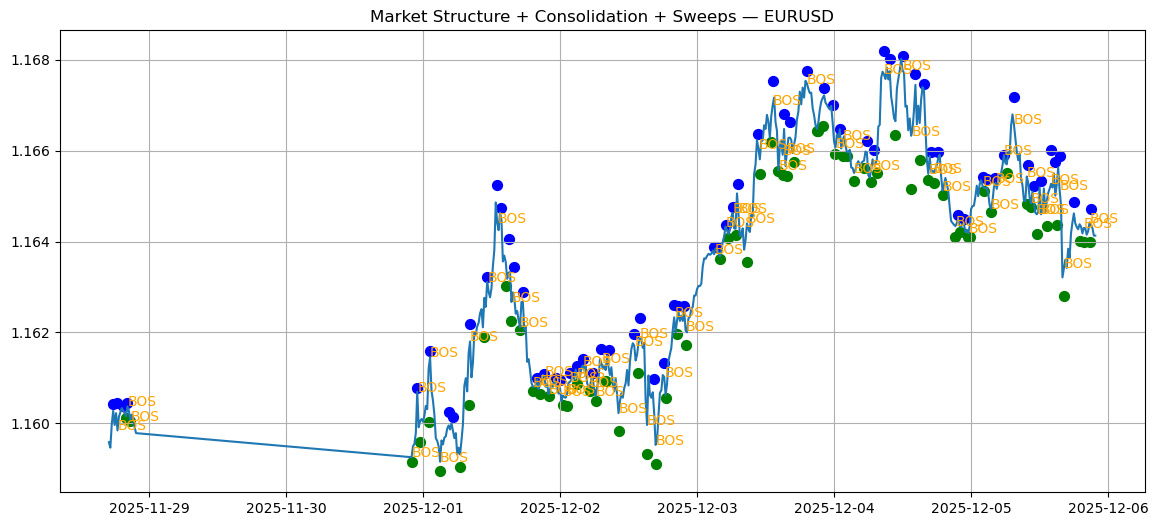


Analyzing GBPUSD...


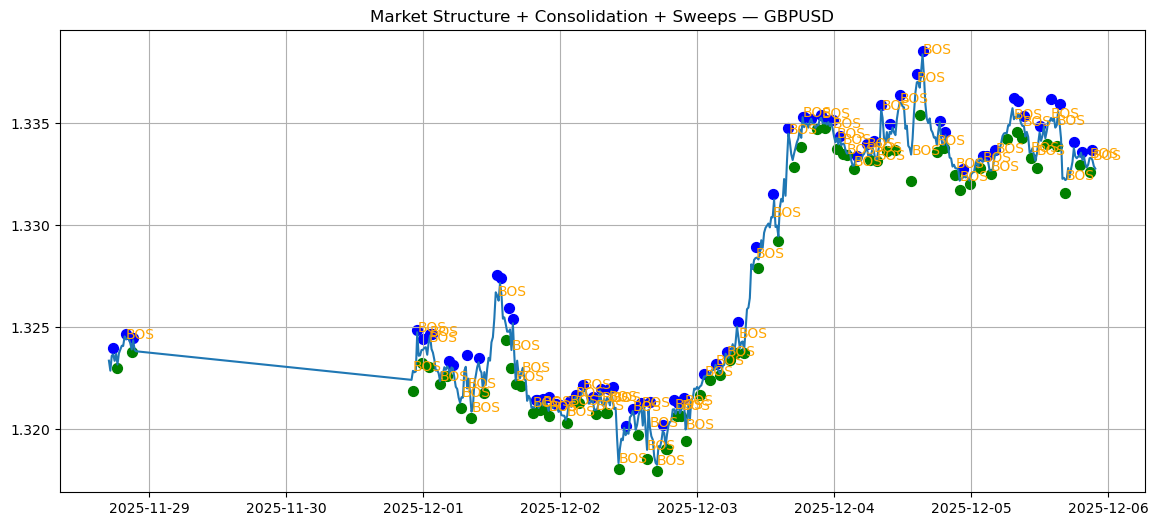


Analyzing XAUUSD...


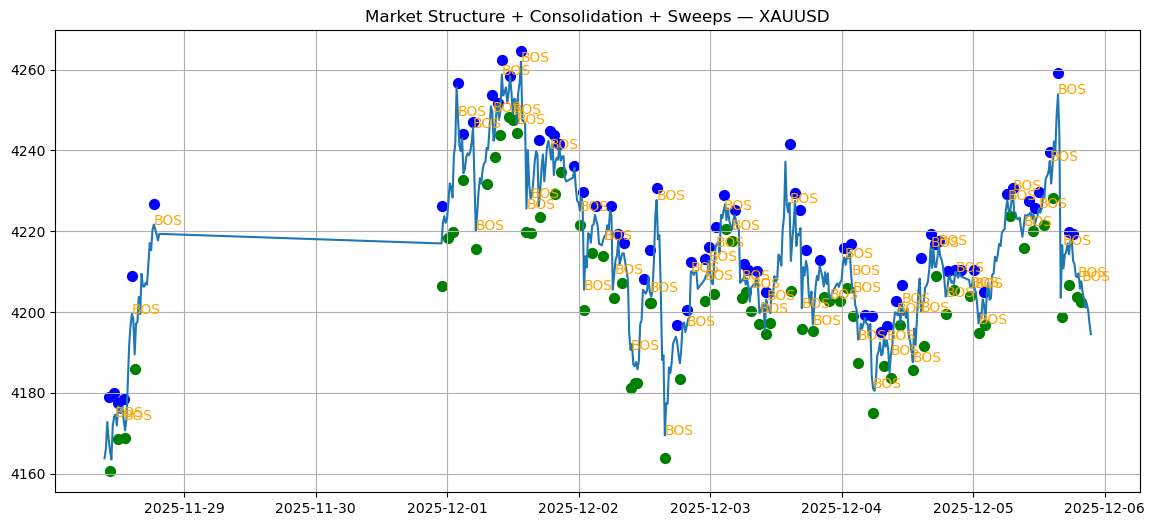


Analyzing Volatility 10 Index...


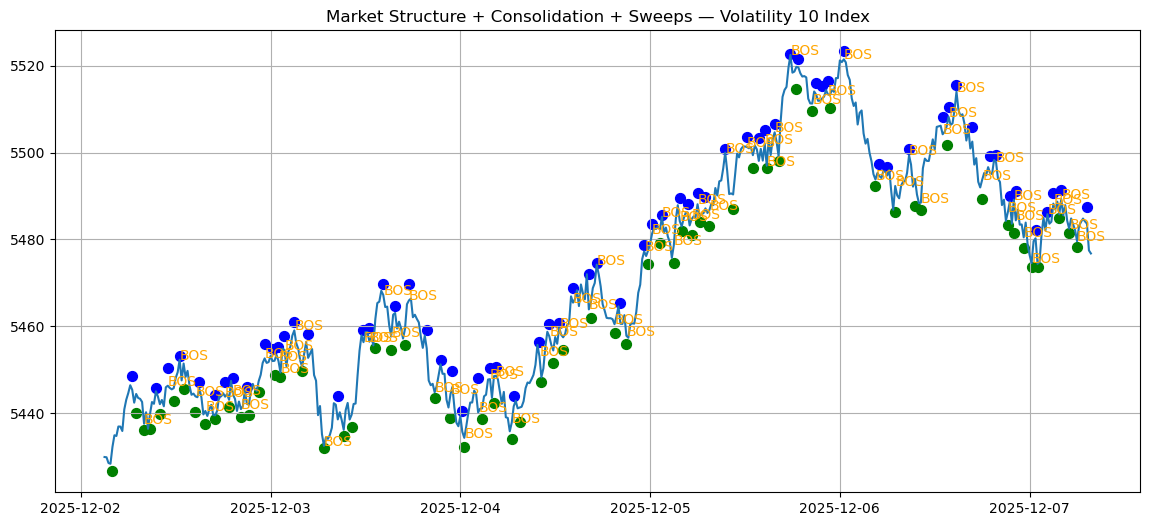


Analyzing Volatility 25 Index...


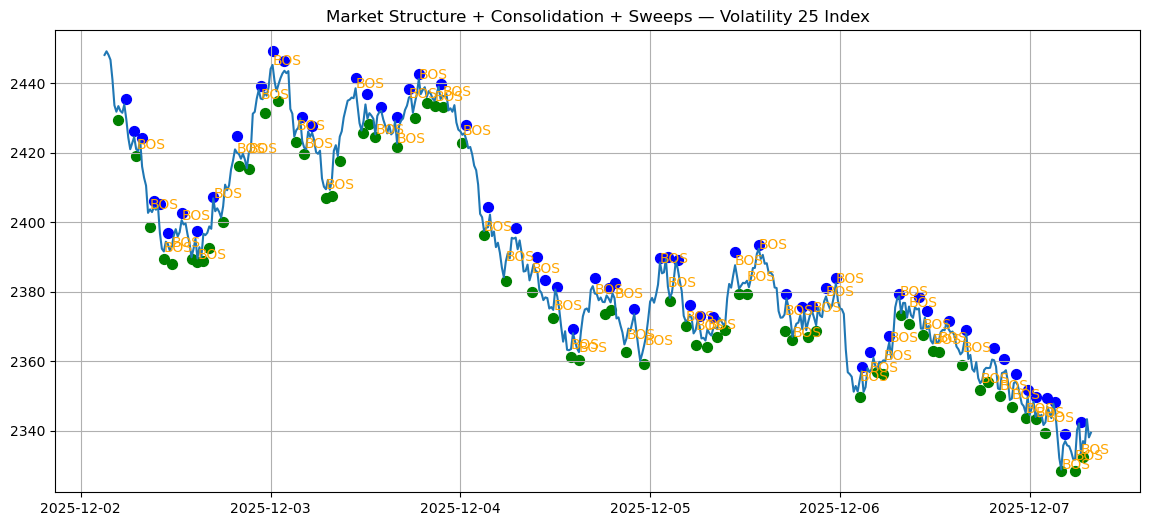


Analyzing Volatility 50 Index...


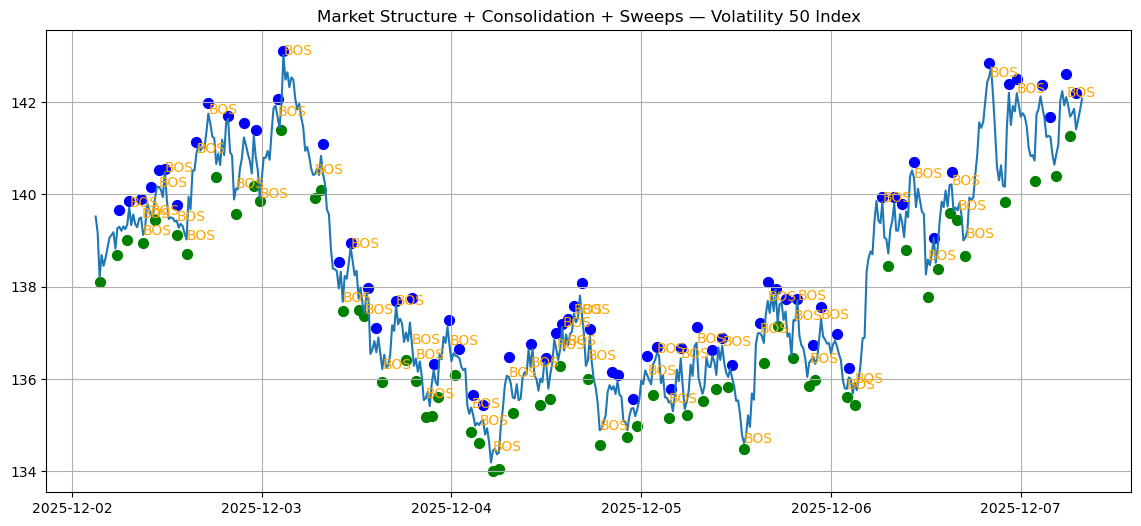


Analyzing Volatility 75 Index...


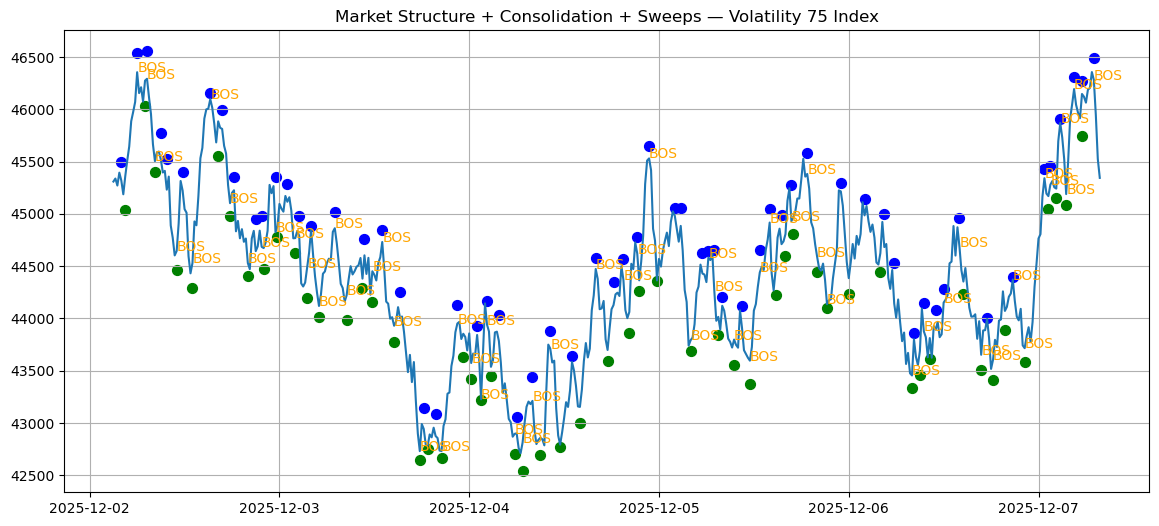


Analyzing Volatility 100 Index...


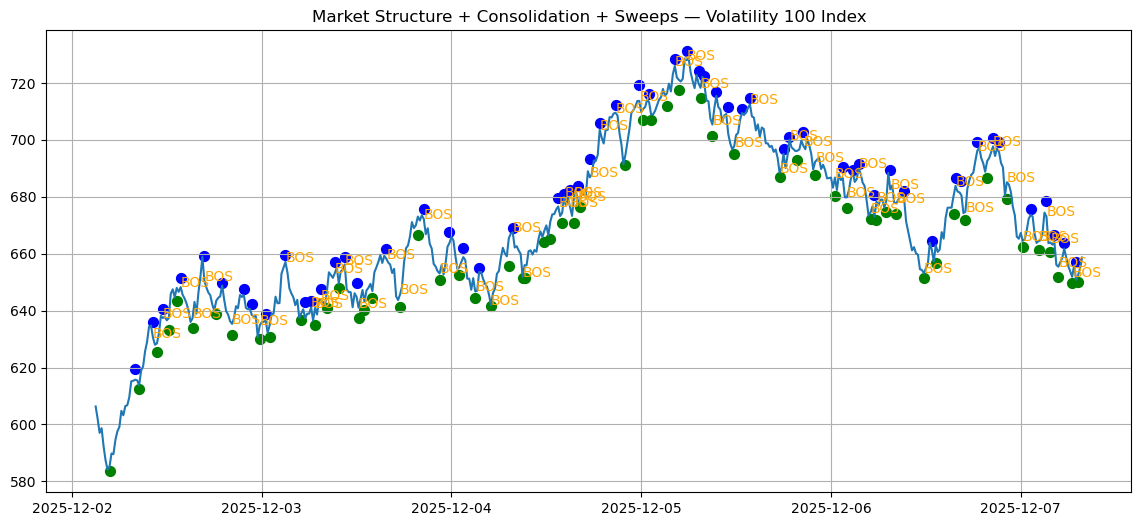


Analyzing Volatility 10 (1s) Index...


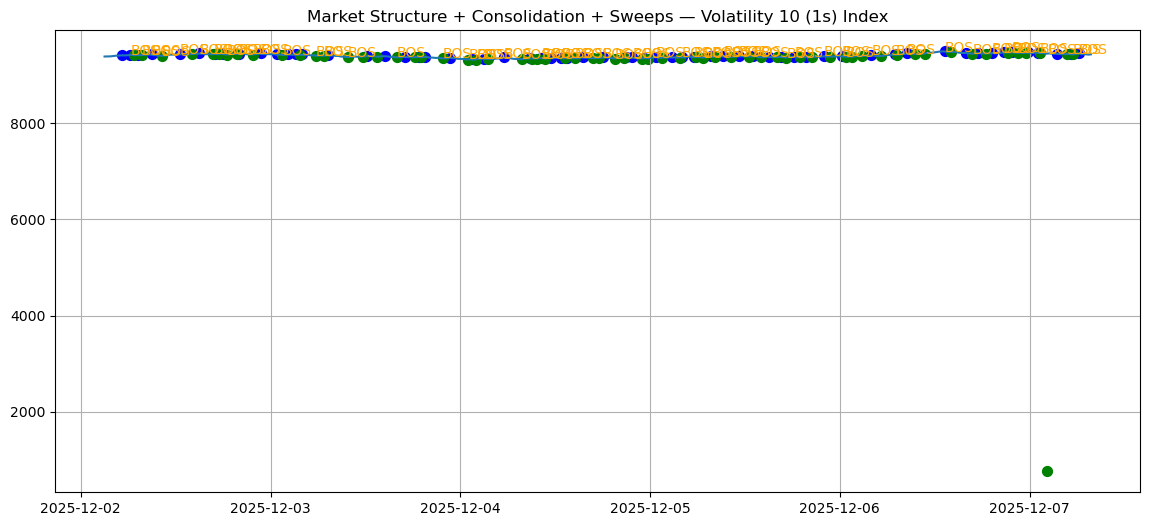


Analyzing Volatility 25 (1s) Index...


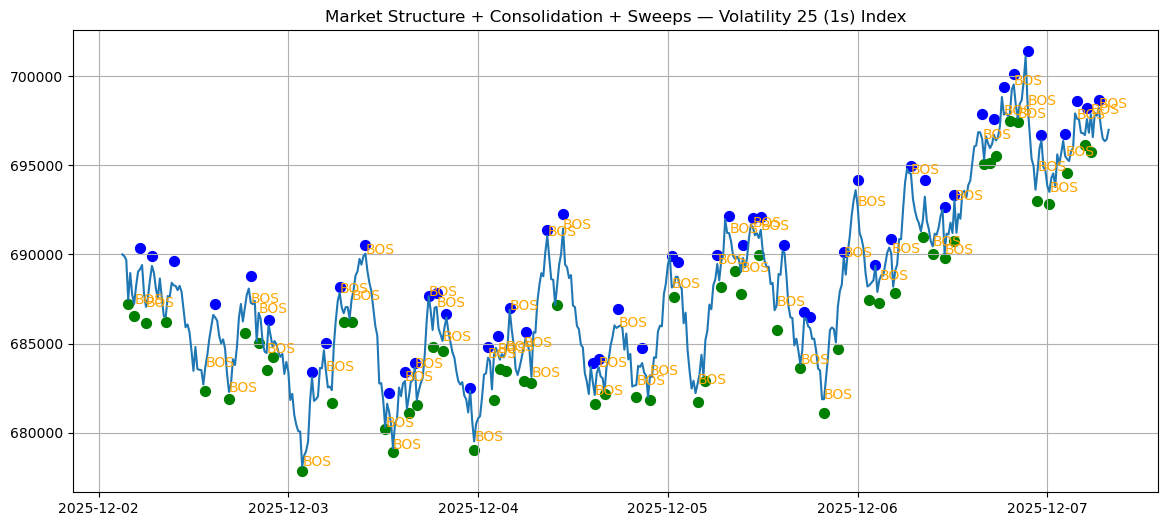


Analyzing Volatility 50 (1s) Index...


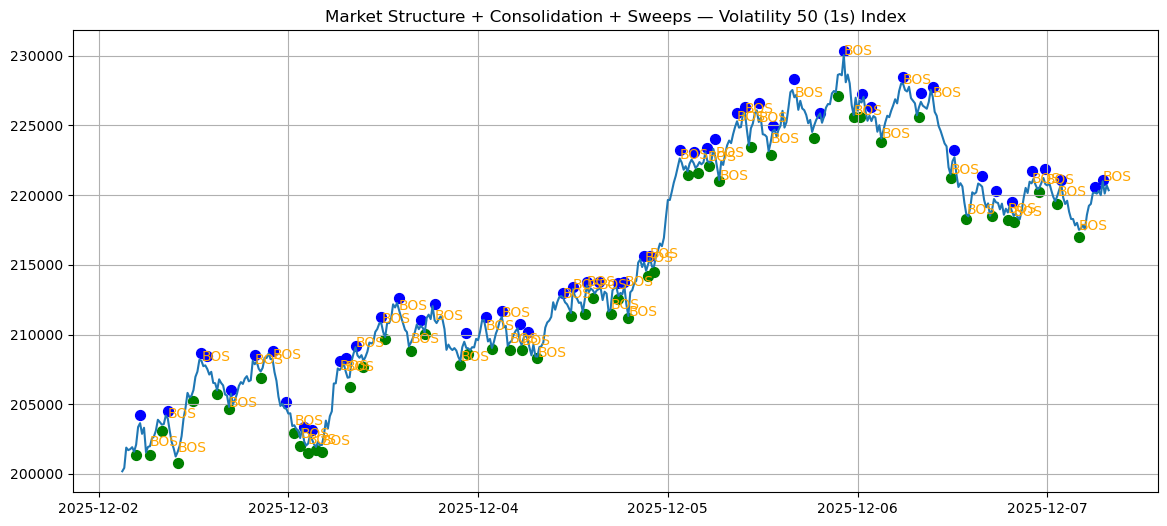


Analyzing Volatility 75 (1s) Index...


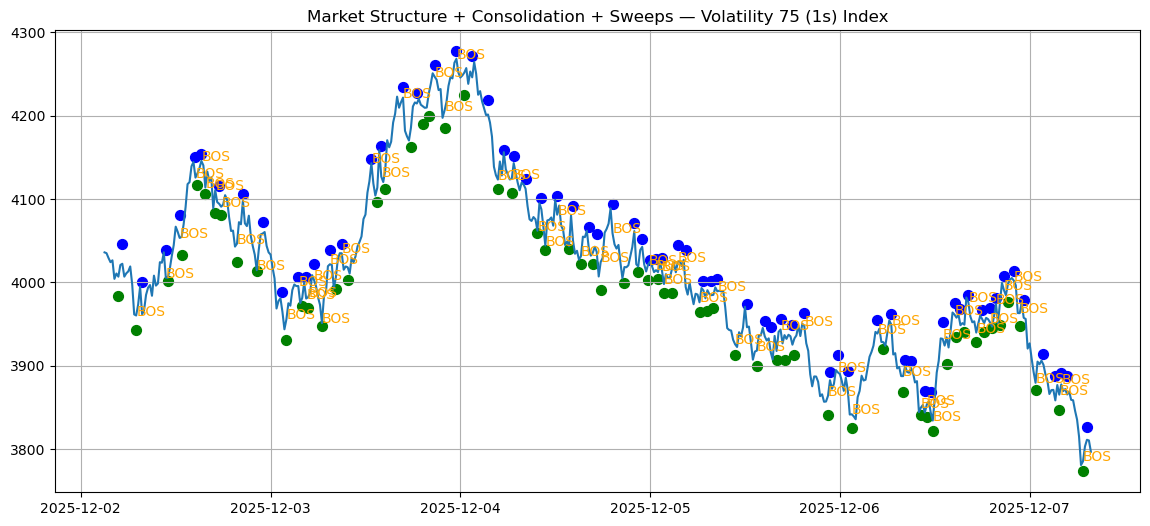


Analyzing Volatility 100 (1s) Index...


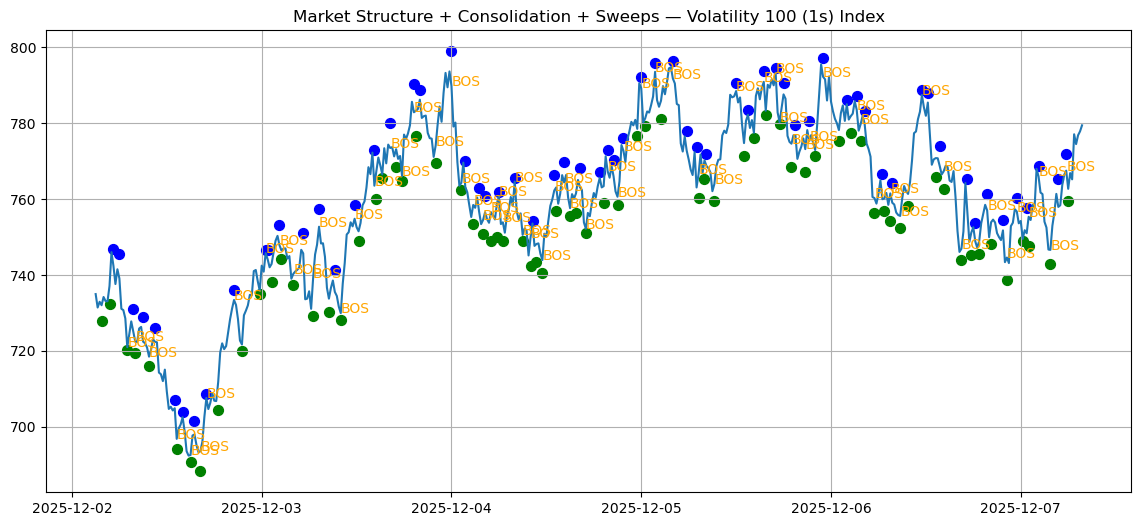


Analyzing Volatility 50 (1s) Index...


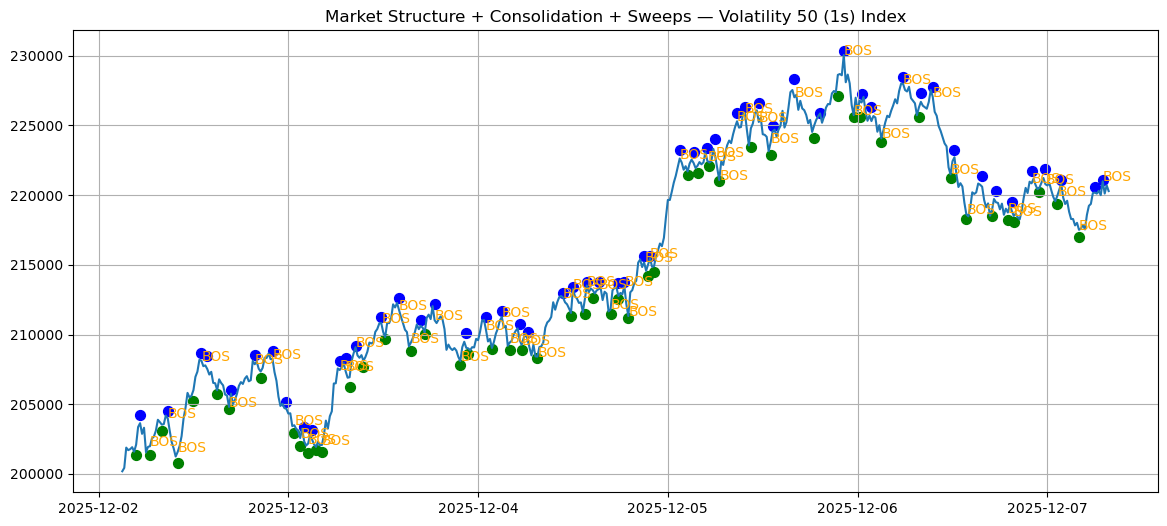


Analyzing Jump 10 Index...


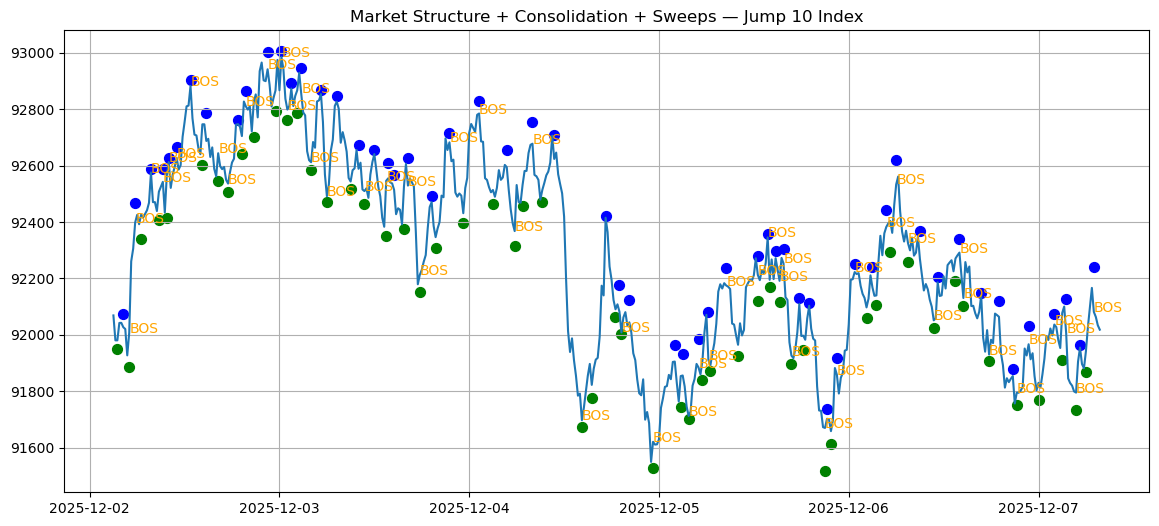


Analyzing Jump 25 Index...


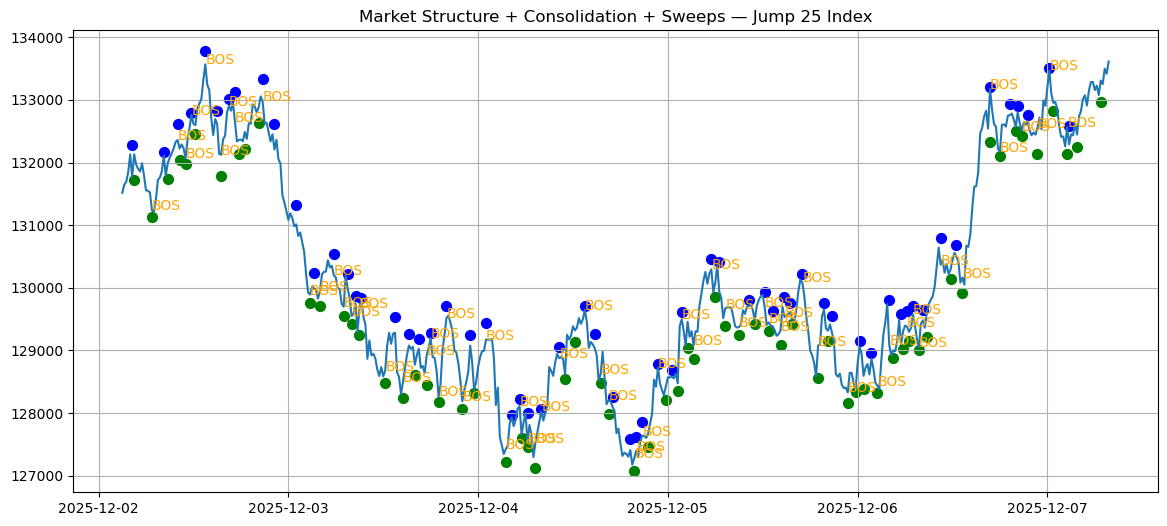


Analyzing Jump 50 Index...


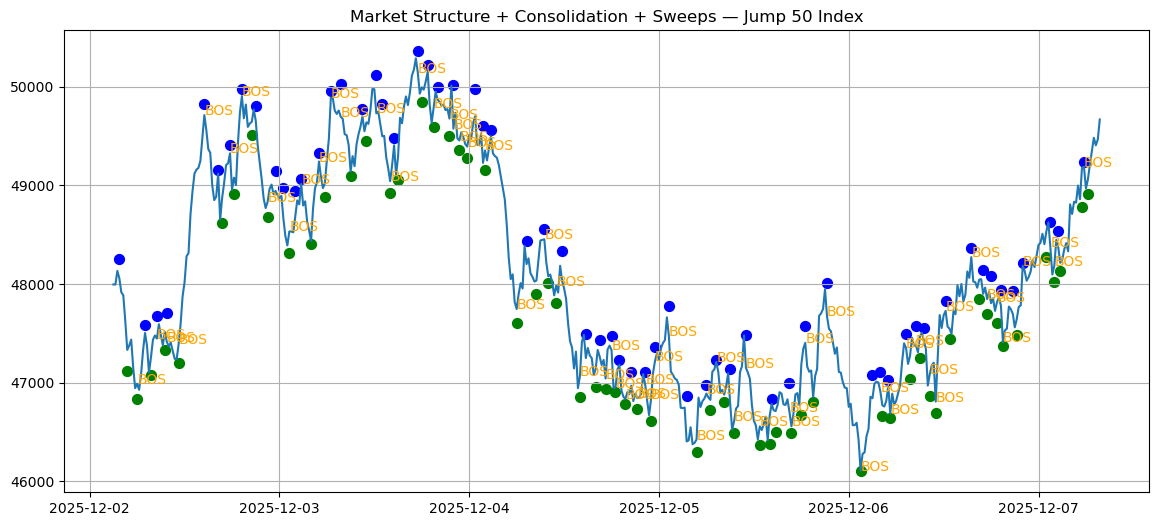


Analyzing Jump 75 Index...


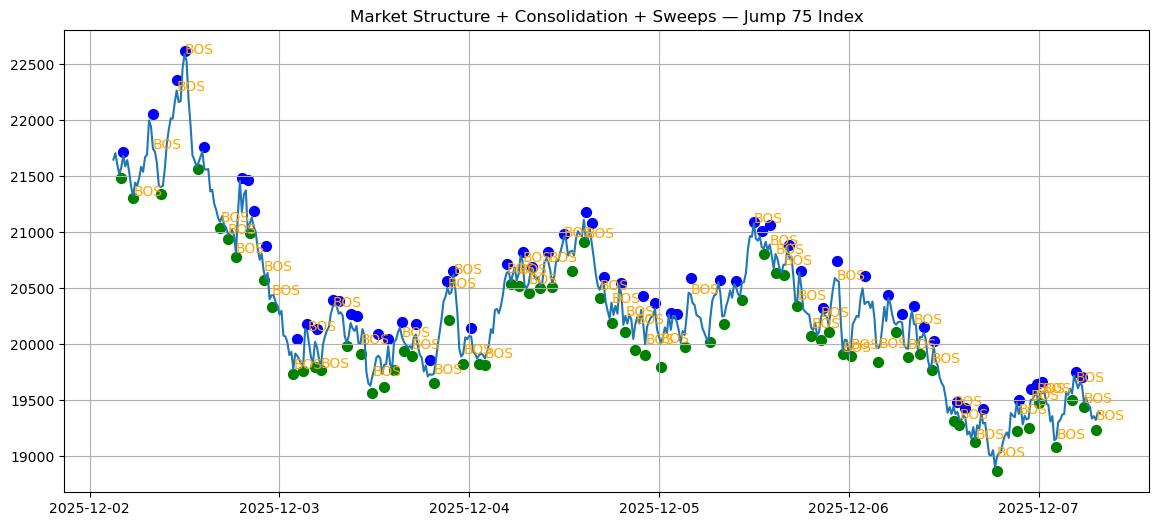


Analyzing Jump 100 Index...


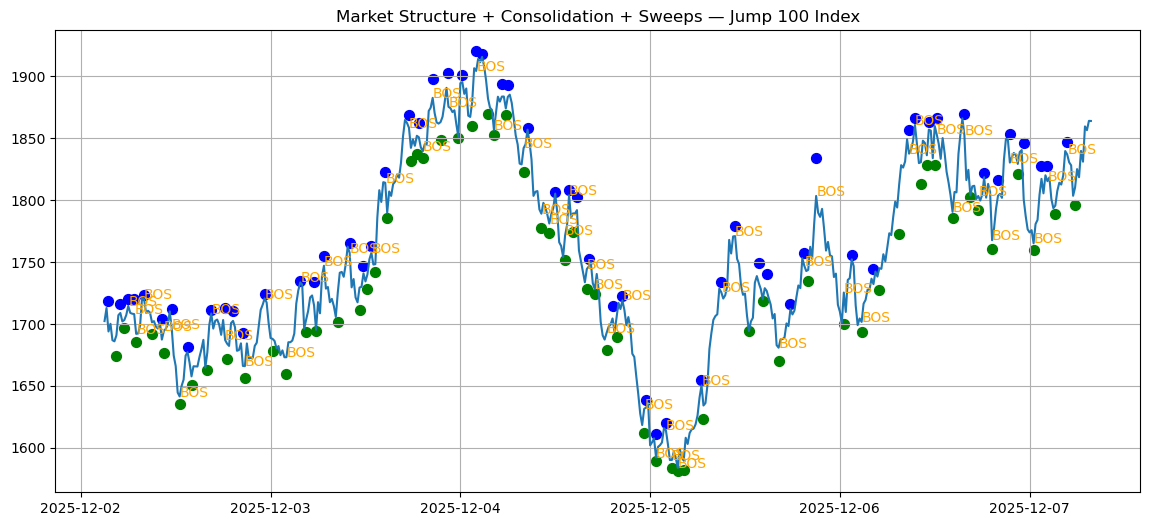

In [52]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


# -----------------------------------------------------------
# 1) CONNECT TO MT5
# -----------------------------------------------------------
if not mt5.initialize():
    raise RuntimeError("Failed to initialize MT5")

print("MT5 initialized:", mt5.terminal_info().name)


# -----------------------------------------------------------
# 2) FETCH MT5 DATA
# -----------------------------------------------------------
def get_mt5_data(symbol, timeframe=mt5.TIMEFRAME_M15, bars=500):
    rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, bars)
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    return df


# -----------------------------------------------------------
# 3) SWING HIGH / SWING LOW DETECTOR
# -----------------------------------------------------------
def find_swings(df, left=2, right=2):
    highs = df['high']
    lows = df['low']

    swing_highs = []
    swing_lows = []

    for i in range(left, len(df) - right):
        if highs[i] == max(highs[i-left:i+right+1]):
            swing_highs.append(i)
        if lows[i] == min(lows[i-left:i+right+1]):
            swing_lows.append(i)

    return swing_highs, swing_lows


# -----------------------------------------------------------
# 4) MARKET STRUCTURE: BOS & CHOCH DETECTOR
# -----------------------------------------------------------
def detect_market_structure(df, sh, sl):
    structure = []

    last_high = None
    last_low = None
    direction = None  # "bullish" / "bearish"

    for i in range(len(df)):
        if i in sh:
            if last_high is None:
                last_high = i
            else:
                if df['high'][i] > df['high'][last_high]:
                    structure.append(("BOS", "up", i))
                    direction = "bullish"
                last_high = i

        if i in sl:
            if last_low is None:
                last_low = i
            else:
                if df['low'][i] < df['low'][last_low]:
                    structure.append(("BOS", "down", i))
                    direction = "bearish"
                last_low = i

        # CHOCH (change character)
        if last_high and last_low and direction:
            if direction == "bullish" and i in sl:
                if df['low'][i] < df['low'][last_low]:
                    structure.append(("CHOCH", "down", i))
                    direction = "bearish"

            if direction == "bearish" and i in sh:
                if df['high'][i] > df['high'][last_high]:
                    structure.append(("CHOCH", "up", i))
                    direction = "bullish"

    return structure


# -----------------------------------------------------------
# 5) CONSOLIDATION (Same as before)
# -----------------------------------------------------------
def find_consolidation(df, window=20, threshold_pips=20, point=0.0001):
    price_th = threshold_pips * point

    rolling_high = df['high'].rolling(window).max()
    rolling_low = df['low'].rolling(window).min()

    df['range'] = rolling_high - rolling_low

    mask = df['range'] < price_th

    if mask.any():
        idx = mask[mask == True].index[-1]
        start_idx = max(0, idx - window)

        return (
            1,
            rolling_low[idx],
            rolling_high[idx],
            df['time'][start_idx],
            df['time'][idx]
        )

    return 0, None, None, None, None


# -----------------------------------------------------------
# 6) DETECT STOP-LOSS HUNT (LIQUIDITY SWEEP)
# -----------------------------------------------------------
def detect_sweep(df, sh, sl, cons_low, cons_high):
    sweeps = []

    for i in sh:
        if df['high'][i] > cons_high:   # swept the top
            sweeps.append(("sweep_up", i))

    for i in sl:
        if df['low'][i] < cons_low:    # swept the bottom
            sweeps.append(("sweep_down", i))

    return sweeps


# -----------------------------------------------------------
# 7) PLOT EVERYTHING: CONSOLIDATION + SWINGS + BOS/CHOCH + SWEEPS
# -----------------------------------------------------------
def plot_structure(df, sh, sl, structure, sweeps, cons_low, cons_high, start, end, symbol):
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(df['time'], df['close'], label="Close")

    # Draw consolidation rectangle
    if cons_low and cons_high:
        ax.add_patch(
            plt.Rectangle(
                (start, cons_low),
                (end - start).total_seconds(),
                cons_high - cons_low,
                fill=False,
                edgecolor="red",
                linewidth=2
            )
        )

    # Mark swing highs
    for i in sh:
        ax.scatter(df['time'][i], df['high'][i], color="blue", s=50)

    # Mark swing lows
    for i in sl:
        ax.scatter(df['time'][i], df['low'][i], color="green", s=50)

    # Mark BOS / CHOCH
    for tag, direction, i in structure:
        color = "purple" if tag == "CHOCH" else "orange"
        ax.text(df['time'][i], df['close'][i], tag, color=color)

    # Mark sweeps
    for tag, i in sweeps:
        ax.text(df['time'][i], df['close'][i], tag, color="red")

    ax.set_title(f"Market Structure + Consolidation + Sweeps — {symbol}")
    ax.grid(True)
    plt.show()


# -----------------------------------------------------------
# 8) MAIN FUNCTION
# -----------------------------------------------------------
def analyze_market(symbols):
    for sym in symbols:
        print(f"\nAnalyzing {sym}...")

        df = get_mt5_data(sym)
        point = mt5.symbol_info(sym).point

        # Consolidation detection
        cons, lo, hi, start, end = find_consolidation(df, point=point)

        # Swings
        sh, sl = find_swings(df)

        # Market structure
        structure = detect_market_structure(df, sh, sl)

        # Stop-loss hunts
        sweeps = []
        if cons == 1:
            sweeps = detect_sweep(df, sh, sl, lo, hi)

        # Plot everything
        plot_structure(df, sh, sl, structure, sweeps, lo, hi, start, end, sym)


# -----------------------------------------------------------
# 9) RUN FOR YOUR SYMBOLS
# -----------------------------------------------------------
symbols_to_check = ["EURUSD", "GBPUSD", "XAUUSD", "Volatility 10 Index","Volatility 25 Index","Volatility 50 Index","Volatility 75 Index","Volatility 100 Index",
    "Volatility 10 (1s) Index","Volatility 25 (1s) Index","Volatility 50 (1s) Index","Volatility 75 (1s) Index","Volatility 100 (1s) Index",
    "Volatility 50 (1s) Index", "Jump 10 Index","Jump 25 Index","Jump 50 Index","Jump 75 Index","Jump 100 Index"]

analyze_market(symbols_to_check)


In [58]:

from typing import Tuple, List

# --- Configuration for the Detector ---
# Default parameters for the MQL5 function port
DEFAULT_NUM_OF_BARS = 50 
DEFAULT_SL_HUNT_PERCENTAGE = 0.05 # 5% of zone height for the hunt threshold
DEFAULT_TIMEFRAME = TF_MT5

# New list of symbols provided by the user
SYMBOL_LIST: List[str] = [
    "EURUSD", "GBPUSD", "XAUUSD", "Volatility 10 Index","Volatility 25 Index","Volatility 50 Index","Volatility 75 Index","Volatility 100 Index",
    "Volatility 10 (1s) Index","Volatility 25 (1s) Index","Volatility 50 (1s) Index","Volatility 75 (1s) Index","Volatility 100 (1s) Index",
    "Volatility 50 (1s) Index", "Jump 10 Index","Jump 25 Index","Jump 50 Index","Jump 75 Index","Jump 100 Index"
]

# Set default symbol to the first in the list for single-variable reference
DEFAULT_SYMBOL = SYMBOL_LIST[0] 

# Chart Object Configuration
CHART_OBJ_NAME = "MQL5_Consolidation"


def connect_mt5() -> bool:
    """Initializes and connects to the MT5 terminal."""
    if not mt5.initialize():
        print(f"MT5 initialization failed. Error code: {mt5.last_error()}")
        return False
    # Check if we are connected, necessary if running standalone
    if not mt5.terminal_info():
        print("MT5 terminal not running or connection failed after initialization.")
        return False
    return True

def clear_chart_objects(symbol: str, timeframe: int, prefix: str):
    """Removes all chart objects starting with a specific prefix."""
    try:
        chart_id = mt5.chart_id(symbol, timeframe)
    except AttributeError:
        return 
        
    if chart_id == 0:
        return

    objects = mt5.chart_objects_get_all(chart_id, symbol)
    if objects is not None:
        for obj_name in objects:
            if obj_name.startswith(prefix):
                mt5.chart_object_delete(chart_id, obj_name)


def draw_chart_rectangle(symbol: str, timeframe: int, range_high: float, range_low: float, start_timestamp: int, end_timestamp: int):
    """Draws a rectangle object on the MT5 chart showing the consolidation zone."""
    try:
        chart_id = mt5.chart_id(symbol, timeframe)
    except AttributeError:
        return 
        
    if chart_id == 0:
        return

    # 1. Clear previous objects
    clear_chart_objects(symbol, timeframe, CHART_OBJ_NAME)
    
    # 2. Add the rectangle object
    obj_name = CHART_OBJ_NAME
    result = mt5.chart_object_add(
        chart_id, obj_name, mt5.OBJ_RECTANGLE, 0, 
        start_timestamp, range_high, 
        end_timestamp, range_low
    )
    
    if result:
        # 3. Set object properties
        mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_COLOR, 0x00FF00) # Green 
        mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_STYLE, mt5.STYLE_SOLID)
        mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_WIDTH, 2)
        mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_BACK, 1)
        mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_FILL, 1)
        mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_BGCOLOR, 0x2000FF00) # Semi-transparent green
        
        print(f"  [Drawing] Consolidation box drawn for {symbol}.")
    else:
        print(f"  [Drawing] Failed to draw chart object. Error: {mt5.last_error()}")


def consolidation_detector_mq_logic(
    symbol: str, 
    timeframe: int, 
    num_of_bars: int, 
    stop_loss_hunt_percentage: float = DEFAULT_SL_HUNT_PERCENTAGE
) -> Tuple[int, float, float]:
    """
    Detects consolidation and stop-loss hunts based on MQL5 logic.

    This function attempts to mirror the MQL5-style calculations exactly.

    :param symbol: Trading instrument.
    :param timeframe: Timeframe (e.g., mt5.TIMEFRAME_M1).
    :param num_of_bars: Number of past bars to analyze (starts from bar 1).
    :param stop_loss_hunt_percentage: Percentage of zone height for SL hunt threshold.
    :return: Tuple (result_code, highest_in_zone, lowest_in_zone)
             Code: 1 (Bullish Hunt), 2 (Bearish Hunt), -1 (Consolidation/Error/No Hunt), 0 (No Consolidation)
    """
    # The connection check is done in the main loop now, but we'll keep a local check for safety.
    if not mt5.terminal_info(): 
        return -99, 0.0, 0.0 # Use a distinct code for disconnected state
    
    # --- 1. Data Retrieval ---
    # Copy data starting from index 1 (the bar before the current index 0 bar)
    rates = mt5.copy_rates_from_pos(symbol, timeframe, 1, num_of_bars)

    if rates is None or len(rates) != num_of_bars:
        print(f"  [Data Error] Failed to retrieve {num_of_bars} bars starting from bar 1 for {symbol}. Got {len(rates) if rates is not None else 0}.")
        clear_chart_objects(symbol, timeframe, CHART_OBJ_NAME)
        return -1, 0.0, 0.0

    df = pd.DataFrame(rates)
    
    # --- 2. Calculation of Price Differences and Ranges ---
    
    # Calculate price differences between consecutive bars (lag = 1)
    df['high_diff'] = df['high'].diff().abs().fillna(0) # high[i] - high[i-1]
    df['low_diff'] = df['low'].diff().abs().fillna(0)   # low[i] - low[i-1]
    
    # Sums are over bars 1 to N-1 (df indices 1 to N-1)
    high_diff_sum = df['high_diff'].iloc[1:].sum()
    low_diff_sum = df['low_diff'].iloc[1:].sum()
    high_bar_sum = df['high'].iloc[1:].sum()
    low_bar_sum = df['low'].iloc[1:].sum()
    
    # Calculate True Range (TR)
    df['range1'] = df['high'] - df['low']
    # shift(1) here is used because the data is *already* reversed (index 0 is newest bar 1)
    # The MQL5 logic uses close[i-1] for bar[i]. In our Pandas DF (bar 1 -> index 0), 
    # we need the close of the *previous* bar (bar 2 -> index 1) for the true range calculation.
    # The MQL5 code used ArraySetAsSeries(..., true) which means index 0 is the newest copied bar.
    # When copying from position 1 (CopyHigh(..., 1, ...)), index 0 corresponds to chart bar 1.
    # Therefore, close[i-1] corresponds to close.shift(1) if we iterate from i=1 up.
    df['range2'] = (df['high'] - df['close'].shift(1)).abs().fillna(0) 
    df['range3'] = (df['low'] - df['close'].shift(1)).abs().fillna(0)
    
    # True Range for bar[i] is max of (H[i]-L[i]), |H[i]-C[i-1]|, |L[i]-C[i-1]|
    df['true_range'] = df[['range1', 'range2', 'range3']].max(axis=1)

    # True Range Sum is over bars 1 to N-1 (i.e., df indices 1 to N-1)
    true_range_sum = df['true_range'].iloc[1:].sum()
    
    # Denominator for averages (N-1)
    n_minus_1 = num_of_bars - 1
    if n_minus_1 <= 0: 
        clear_chart_objects(symbol, timeframe, CHART_OBJ_NAME)
        return -1, 0.0, 0.0

    # --- 3. Calculation of Averages and Zone Metrics ---
    
    # Averages over N-1 bars (index 1 to N-1)
    high_bar_sum_avg = high_bar_sum / n_minus_1
    low_bar_sum_avg = low_bar_sum / n_minus_1
    bar_range_avg = high_bar_sum_avg - low_bar_sum_avg
    avg_true_range = true_range_sum / n_minus_1
    
    # Zone Height (Absolute High/Low over all N bars, index 0 to N-1)
    highest_in_zone = df['high'].max()
    lowest_in_zone = df['low'].min()
    zone_height = highest_in_zone - lowest_in_zone
    
    # Top/Low Diff (using the MQL5 formula logic)
    top_diff = high_bar_sum_avg - (high_diff_sum / n_minus_1)
    low_diff = low_bar_sum_avg - (low_diff_sum / n_minus_1)
    price_gap = top_diff - low_diff
    
    # --- 4. Consolidation Detection Logic ---
    is_consolidating = False
    if (price_gap < bar_range_avg) and (price_gap < avg_true_range):
        is_consolidating = True
        print(f"  [MQL Logic] Consolidation detected for {symbol} ({num_of_bars} bars).")
        print(f"    Check: Price Gap ({price_gap:.5f}) < Range Avg ({bar_range_avg:.5f}) AND Price Gap ({price_gap:.5f}) < ATR Avg ({avg_true_range:.5f})")
        
        # Draw the rectangle around the detected zone (all N bars)
        start_timestamp = df['time'].min() # Time of the oldest bar (index N-1)
        end_timestamp = df['time'].iloc[0] # Time of the newest bar (index 0)
        draw_chart_rectangle(symbol, timeframe, highest_in_zone, lowest_in_zone, start_timestamp, end_timestamp)
        
        # --- 5. Stop-Loss Hunt Logic (Check against the current bar, index 0) ---
        
        # Get the current bar data (Index 0)
        current_rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, 1)
        if current_rates is None or len(current_rates) == 0:
            print("  [SL Hunt] Failed to get current bar data.")
            return -1, highest_in_zone, lowest_in_zone
            
        current_high = current_rates[0]['high']
        current_low = current_rates[0]['low']
        
        # Calculate stop-loss hunt thresholds
        upper_sl_threshold = highest_in_zone + (zone_height * stop_loss_hunt_percentage)
        lower_sl_threshold = lowest_in_zone - (zone_height * stop_loss_hunt_percentage)
        
        print(f"  [SL Hunt Check] Zone H/L: {highest_in_zone:.5f}/{lowest_in_zone:.5f}. Threshold H/L: {upper_sl_threshold:.5f}/{lower_sl_threshold:.5f}. Current H/L: {current_high:.5f}/{current_low:.5f}")

        # Bullish stop-loss hunt (Sweep down)
        if current_low < lower_sl_threshold: 
            print("  [SL Hunt] Bullish Stop-Loss Hunt (Sweep Down) Detected. Result = 1.")
            return 1, highest_in_zone, lowest_in_zone
            
        # Bearish stop-loss hunt (Sweep up)
        elif current_high > upper_sl_threshold: 
            print("  [SL Hunt] Bearish Stop-Loss Hunt (Sweep Up) Detected. Result = 2.")
            return 2, highest_in_zone, lowest_in_zone
            
        else:
            # Consolidation detected, but no hunt on the current bar
            print("  [Result] Consolidation detected, no hunt on current bar. Result = -1.")
            return -1, highest_in_zone, lowest_in_zone
            
    else:
        # No consolidation detected, clear any previous drawing
        clear_chart_objects(symbol, timeframe, CHART_OBJ_NAME)
        print(f"  [MQL Logic] No consolidation detected for {symbol}. Result = 0.")
        return 0, 0.0, 0.0


# ==============================================================================
# --- Example Execution (Simulating a Jupyter Cell Run) ---
# ==============================================================================

if __name__ == '__main__':
    
    # 1. Connect to MT5
    if connect_mt5():
        
        print(f"Starting MQL5 Consolidation Detector Check for {len(SYMBOL_LIST)} symbols...")
        
        # 2. Define parameters
        timeframe_to_check = mt5.TIMEFRAME_M15 # Using M15 for a better chance of seeing consolidation
        bars = 100
        hunt_perc = 0.02 # Use 2% tolerance for the hunt
        
        all_results = []

        for symbol_to_check in SYMBOL_LIST:
            print(f"\n--- Checking Symbol: {symbol_to_check} ---")
            
            # Ensure the symbol is selected and visible
            if not mt5.symbol_select(symbol_to_check, True):
                print(f"  [ERROR] Failed to select symbol {symbol_to_check}. Skipping.")
                all_results.append({
                    'Symbol': symbol_to_check,
                    'Timeframe': timeframe_to_check,
                    'Result_Code': -999,
                    'Highest_Price': 0.0,
                    'Lowest_Price': 0.0,
                    'Status': 'Symbol Not Selectable'
                })
                continue

            # 3. Execute the function
            result_code, high, low = consolidation_detector_mq_logic(
                symbol_to_check, 
                timeframe_to_check, 
                bars, 
                hunt_perc
            )
            
            # 4. Collect results
            all_results.append({
                'Symbol': symbol_to_check,
                'Timeframe': timeframe_to_check,
                'Result_Code': result_code,
                'Highest_Price': f"{high:.5f}" if high != 0.0 else 'N/A',
                'Lowest_Price': f"{low:.5f}" if low != 0.0 else 'N/A',
                'Status': 'Consolidation Found (No Hunt)' if result_code == -1 else 
                          'Bullish Hunt Detected' if result_code == 1 else
                          'Bearish Hunt Detected' if result_code == 2 else
                          'No Consolidation' if result_code == 0 else 
                          'Data/Logic Error'
            })

        # 5. Display aggregated results
        if all_results:
            final_df = pd.DataFrame(all_results)
            print("\n" + "="*80)
            print("--- AGGREGATED CONSOLIDATION DETECTION RESULTS ---")
            print("="*80)
            pd.set_option('display.max_rows', None) 
            print(final_df.to_string(index=False))

        
        # 6. Shutdown connection
        mt5.shutdown()
        print("\nMT5 connection successfully shut down.")
    else:
        print("\nCould not execute detector function because MT5 failed to connect or initialize.")

Starting MQL5 Consolidation Detector Check for 19 symbols...

--- Checking Symbol: EURUSD ---
  [MQL Logic] Consolidation detected for EURUSD (100 bars).
    Check: Price Gap (0.00041) < Range Avg (0.00043) AND Price Gap (0.00041) < ATR Avg (0.00043)
  [SL Hunt Check] Zone H/L: 1.16718/1.16280. Threshold H/L: 1.16727/1.16271. Current H/L: 1.16432/1.16411
  [Result] Consolidation detected, no hunt on current bar. Result = -1.

--- Checking Symbol: GBPUSD ---
  [MQL Logic] Consolidation detected for GBPUSD (100 bars).
    Check: Price Gap (0.00059) < Range Avg (0.00061) AND Price Gap (0.00059) < ATR Avg (0.00061)
  [SL Hunt Check] Zone H/L: 1.33624/1.33161. Threshold H/L: 1.33633/1.33152. Current H/L: 1.33313/1.33271
  [Result] Consolidation detected, no hunt on current bar. Result = -1.

--- Checking Symbol: XAUUSD ---
  [MQL Logic] No consolidation detected for XAUUSD. Result = 0.

--- Checking Symbol: Volatility 10 Index ---
  [MQL Logic] Consolidation detected for Volatility 10 Index

In [59]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
from typing import Tuple, List

# --- Configuration for the Detector ---
# Default parameters for the MQL5 function port
DEFAULT_NUM_OF_BARS = 50 
DEFAULT_SL_HUNT_PERCENTAGE = 0.05 # 5% of zone height for the hunt threshold
DEFAULT_TIMEFRAME = mt5.TIMEFRAME_M1

# New list of symbols provided by the user
SYMBOL_LIST: List[str] = [
    "EURUSD", "GBPUSD", "XAUUSD", "Volatility 10 Index","Volatility 25 Index","Volatility 50 Index","Volatility 75 Index","Volatility 100 Index",
    "Volatility 10 (1s) Index","Volatility 25 (1s) Index","Volatility 50 (1s) Index","Volatility 75 (1s) Index","Volatility 100 (1s) Index",
    "Volatility 50 (1s) Index", "Jump 10 Index","Jump 25 Index","Jump 50 Index","Jump 75 Index","Jump 100 Index"
]

# Set default symbol to the first in the list for single-variable reference
DEFAULT_SYMBOL = SYMBOL_LIST[0] 

# Chart Object Configuration
CHART_OBJ_NAME = "MQL5_Consolidation"


def connect_mt5() -> bool:
    """Initializes and connects to the MT5 terminal."""
    if not mt5.initialize():
        print(f"MT5 initialization failed. Error code: {mt5.last_error()}")
        return False
    # Check if we are connected, necessary if running standalone
    if not mt5.terminal_info():
        print("MT5 terminal not running or connection failed after initialization.")
        return False
    return True

def clear_chart_objects(symbol: str, timeframe: int, prefix: str):
    """Removes all chart objects starting with a specific prefix."""
    try:
        chart_id = mt5.chart_id(symbol, timeframe)
    except AttributeError:
        return 
        
    if chart_id == 0:
        return

    objects = mt5.chart_objects_get_all(chart_id, symbol)
    if objects is not None:
        for obj_name in objects:
            if obj_name.startswith(prefix):
                mt5.chart_object_delete(chart_id, obj_name)


def draw_chart_rectangle(symbol: str, timeframe: int, range_high: float, range_low: float, start_timestamp: int, end_timestamp: int):
    """Draws a rectangle object on the MT5 chart showing the consolidation zone."""
    try:
        chart_id = mt5.chart_id(symbol, timeframe)
    except AttributeError:
        return 
        
    if chart_id == 0:
        return

    # 1. Clear previous objects
    clear_chart_objects(symbol, timeframe, CHART_OBJ_NAME)
    
    # 2. Add the rectangle object
    obj_name = CHART_OBJ_NAME
    result = mt5.chart_object_add(
        chart_id, obj_name, mt5.OBJ_RECTANGLE, 0, 
        start_timestamp, range_high, 
        end_timestamp, range_low
    )
    
    if result:
        # 3. Set object properties
        mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_COLOR, 0x00FF00) # Green 
        mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_STYLE, mt5.STYLE_SOLID)
        mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_WIDTH, 2)
        mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_BACK, 1)
        mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_FILL, 1)
        mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_BGCOLOR, 0x2000FF00) # Semi-transparent green
        
        print(f"  [Drawing] Consolidation box drawn for {symbol}.")
    else:
        print(f"  [Drawing] Failed to draw chart object. Error: {mt5.last_error()}")


def consolidation_detector_mq_logic(
    symbol: str, 
    timeframe: int, 
    num_of_bars: int, 
    stop_loss_hunt_percentage: float = DEFAULT_SL_HUNT_PERCENTAGE
) -> Tuple[int, float, float]:
    """
    Detects consolidation and stop-loss hunts based on MQL5 logic.

    This function attempts to mirror the MQL5-style calculations exactly.

    :param symbol: Trading instrument.
    :param timeframe: Timeframe (e.g., mt5.TIMEFRAME_M1).
    :param num_of_bars: Number of past bars to analyze (starts from bar 1).
    :param stop_loss_hunt_percentage: Percentage of zone height for SL hunt threshold.
    :return: Tuple (result_code, highest_in_zone, lowest_in_zone)
             Code: 1 (Bullish Hunt), 2 (Bearish Hunt), -1 (Consolidation/Error/No Hunt), 0 (No Consolidation)
    """
    # The connection check is done in the main loop now, but we'll keep a local check for safety.
    if not mt5.terminal_info(): 
        return -99, 0.0, 0.0 # Use a distinct code for disconnected state
    
    # --- 1. Data Retrieval ---
    # Copy data starting from index 1 (the bar before the current index 0 bar)
    rates = mt5.copy_rates_from_pos(symbol, timeframe, 1, num_of_bars)

    if rates is None or len(rates) != num_of_bars:
        print(f"  [Data Error] Failed to retrieve {num_of_bars} bars starting from bar 1 for {symbol}. Got {len(rates) if rates is not None else 0}.")
        clear_chart_objects(symbol, timeframe, CHART_OBJ_NAME)
        return -1, 0.0, 0.0

    df = pd.DataFrame(rates)
    
    # --- 2. Calculation of Price Differences and Ranges ---
    
    # Calculate price differences between consecutive bars (lag = 1)
    df['high_diff'] = df['high'].diff().abs().fillna(0) # high[i] - high[i-1]
    df['low_diff'] = df['low'].diff().abs().fillna(0)   # low[i] - low[i-1]
    
    # Sums are over bars 1 to N-1 (df indices 1 to N-1)
    high_diff_sum = df['high_diff'].iloc[1:].sum()
    low_diff_sum = df['low_diff'].iloc[1:].sum()
    high_bar_sum = df['high'].iloc[1:].sum()
    low_bar_sum = df['low'].iloc[1:].sum()
    
    # Calculate True Range (TR)
    df['range1'] = df['high'] - df['low']
    # shift(1) here is used because the data is *already* reversed (index 0 is newest bar 1)
    # The MQL5 logic uses close[i-1] for bar[i]. In our Pandas DF (bar 1 -> index 0), 
    # we need the close of the *previous* bar (bar 2 -> index 1) for the true range calculation.
    # The MQL5 code used ArraySetAsSeries(..., true) which means index 0 is the newest copied bar.
    # When copying from position 1 (CopyHigh(..., 1, ...)), index 0 corresponds to chart bar 1.
    # Therefore, close[i-1] corresponds to close.shift(1) if we iterate from i=1 up.
    df['range2'] = (df['high'] - df['close'].shift(1)).abs().fillna(0) 
    df['range3'] = (df['low'] - df['close'].shift(1)).abs().fillna(0)
    
    # True Range for bar[i] is max of (H[i]-L[i]), |H[i]-C[i-1]|, |L[i]-C[i-1]|
    df['true_range'] = df[['range1', 'range2', 'range3']].max(axis=1)

    # True Range Sum is over bars 1 to N-1 (i.e., df indices 1 to N-1)
    true_range_sum = df['true_range'].iloc[1:].sum()
    
    # Denominator for averages (N-1)
    n_minus_1 = num_of_bars - 1
    if n_minus_1 <= 0: 
        clear_chart_objects(symbol, timeframe, CHART_OBJ_NAME)
        return -1, 0.0, 0.0

    # --- 3. Calculation of Averages and Zone Metrics ---
    
    # Averages over N-1 bars (index 1 to N-1)
    high_bar_sum_avg = high_bar_sum / n_minus_1
    low_bar_sum_avg = low_bar_sum / n_minus_1
    bar_range_avg = high_bar_sum_avg - low_bar_sum_avg
    avg_true_range = true_range_sum / n_minus_1
    
    # Zone Height (Absolute High/Low over all N bars, index 0 to N-1)
    highest_in_zone = df['high'].max()
    lowest_in_zone = df['low'].min()
    zone_height = highest_in_zone - lowest_in_zone
    
    # Top/Low Diff (using the MQL5 formula logic)
    top_diff = high_bar_sum_avg - (high_diff_sum / n_minus_1)
    low_diff = low_bar_sum_avg - (low_diff_sum / n_minus_1)
    price_gap = top_diff - low_diff
    
    # --- 4. Consolidation Detection Logic ---
    is_consolidating = False
    if (price_gap < bar_range_avg) and (price_gap < avg_true_range):
        is_consolidating = True
        print(f"  [MQL Logic] Consolidation detected for {symbol} ({num_of_bars} bars).")
        print(f"    Check: Price Gap ({price_gap:.5f}) < Range Avg ({bar_range_avg:.5f}) AND Price Gap ({price_gap:.5f}) < ATR Avg ({avg_true_range:.5f})")
        
        # Draw the rectangle around the detected zone (all N bars)
        start_timestamp = df['time'].min() # Time of the oldest bar (index N-1)
        end_timestamp = df['time'].iloc[0] # Time of the newest bar (index 0)
        draw_chart_rectangle(symbol, timeframe, highest_in_zone, lowest_in_zone, start_timestamp, end_timestamp)
        
        # --- 5. Stop-Loss Hunt Logic (Check against the current bar, index 0) ---
        
        # Get the current bar data (Index 0)
        current_rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, 1)
        if current_rates is None or len(current_rates) == 0:
            print("  [SL Hunt] Failed to get current bar data.")
            return -1, highest_in_zone, lowest_in_zone
            
        current_high = current_rates[0]['high']
        current_low = current_rates[0]['low']
        
        # Calculate stop-loss hunt thresholds
        upper_sl_threshold = highest_in_zone + (zone_height * stop_loss_hunt_percentage)
        lower_sl_threshold = lowest_in_zone - (zone_height * stop_loss_hunt_percentage)
        
        print(f"  [SL Hunt Check] Zone H/L: {highest_in_zone:.5f}/{lowest_in_zone:.5f}. Threshold H/L: {upper_sl_threshold:.5f}/{lower_sl_threshold:.5f}. Current H/L: {current_high:.5f}/{current_low:.5f}")

        # Bullish stop-loss hunt (Sweep down)
        if current_low < lower_sl_threshold: 
            print("  [SL Hunt] Bullish Stop-Loss Hunt (Sweep Down) Detected. Result = 1.")
            return 1, highest_in_zone, lowest_in_zone
            
        # Bearish stop-loss hunt (Sweep up)
        elif current_high > upper_sl_threshold: 
            print("  [SL Hunt] Bearish Stop-Loss Hunt (Sweep Up) Detected. Result = 2.")
            return 2, highest_in_zone, lowest_in_zone
            
        else:
            # Consolidation detected, but no hunt on the current bar
            print("  [Result] Consolidation detected, no hunt on current bar. Result = -1.")
            return -1, highest_in_zone, lowest_in_zone
            
    else:
        # No consolidation detected, clear any previous drawing
        clear_chart_objects(symbol, timeframe, CHART_OBJ_NAME)
        print(f"  [MQL Logic] No consolidation detected for {symbol}. Result = 0.")
        return 0, 0.0, 0.0


# ==============================================================================
# --- Example Execution (Simulating a Jupyter Cell Run) ---
# ==============================================================================

if __name__ == '__main__':
    
    # 1. Connect to MT5
    if connect_mt5():
        
        print(f"Starting MQL5 Consolidation Detector Check for {len(SYMBOL_LIST)} symbols...")
        
        # 2. Define parameters
        timeframe_to_check = mt5.TIMEFRAME_M15 # Using M15 for a better chance of seeing consolidation
        bars = 100
        hunt_perc = 0.02 # Use 2% tolerance for the hunt
        
        all_results = []

        for symbol_to_check in SYMBOL_LIST:
            print(f"\n--- Checking Symbol: {symbol_to_check} ---")
            
            # Ensure the symbol is selected and visible
            if not mt5.symbol_select(symbol_to_check, True):
                print(f"  [ERROR] Failed to select symbol {symbol_to_check}. Skipping.")
                all_results.append({
                    'Symbol': symbol_to_check,
                    'Timeframe': timeframe_to_check,
                    'Result_Code': -999,
                    'Highest_Price': 0.0,
                    'Lowest_Price': 0.0,
                    'Status': 'Symbol Not Selectable'
                })
                continue

            # 3. Execute the function
            result_code, high, low = consolidation_detector_mq_logic(
                symbol_to_check, 
                timeframe_to_check, 
                bars, 
                hunt_perc
            )
            
            # 4. Collect results
            all_results.append({
                'Symbol': symbol_to_check,
                'Timeframe': timeframe_to_check,
                'Result_Code': result_code,
                'Highest_Price': f"{high:.5f}" if high != 0.0 else 'N/A',
                'Lowest_Price': f"{low:.5f}" if low != 0.0 else 'N/A',
                'Status': 'Consolidation Found (No Hunt)' if result_code == -1 else 
                          'Bullish Hunt Detected' if result_code == 1 else
                          'Bearish Hunt Detected' if result_code == 2 else
                          'No Consolidation' if result_code == 0 else 
                          'Data/Logic Error'
            })

        # 5. Display aggregated results
        if all_results:
            final_df = pd.DataFrame(all_results)
            print("\n" + "="*80)
            print("--- AGGREGATED CONSOLIDATION DETECTION RESULTS ---")
            print("="*80)
            pd.set_option('display.max_rows', None) 
            print(final_df.to_string(index=False))

        
        # 6. Shutdown connection
        mt5.shutdown()
        print("\nMT5 connection successfully shut down.")
    else:
        print("\nCould not execute detector function because MT5 failed to connect or initialize.")

Starting MQL5 Consolidation Detector Check for 19 symbols...

--- Checking Symbol: EURUSD ---
  [MQL Logic] Consolidation detected for EURUSD (100 bars).
    Check: Price Gap (0.00041) < Range Avg (0.00043) AND Price Gap (0.00041) < ATR Avg (0.00043)
  [SL Hunt Check] Zone H/L: 1.16718/1.16280. Threshold H/L: 1.16727/1.16271. Current H/L: 1.16432/1.16411
  [Result] Consolidation detected, no hunt on current bar. Result = -1.

--- Checking Symbol: GBPUSD ---
  [MQL Logic] Consolidation detected for GBPUSD (100 bars).
    Check: Price Gap (0.00059) < Range Avg (0.00061) AND Price Gap (0.00059) < ATR Avg (0.00061)
  [SL Hunt Check] Zone H/L: 1.33624/1.33161. Threshold H/L: 1.33633/1.33152. Current H/L: 1.33313/1.33271
  [Result] Consolidation detected, no hunt on current bar. Result = -1.

--- Checking Symbol: XAUUSD ---
  [MQL Logic] No consolidation detected for XAUUSD. Result = 0.

--- Checking Symbol: Volatility 10 Index ---
  [MQL Logic] Consolidation detected for Volatility 10 Index

In [14]:
#Use this
from typing import Tuple, List

# --- Configuration for the Detector ---
# Default parameters for the MQL5 function port
DEFAULT_NUM_OF_BARS = 50 
DEFAULT_SL_HUNT_PERCENTAGE = 0.05 # 5% of zone height for the hunt threshold
DEFAULT_TIMEFRAME = mt5.TIMEFRAME_M1

# New list of symbols provided by the user
SYMBOL_LIST: List[str] = [
    "EURUSD", "GBPUSD", "XAUUSD", "Volatility 10 Index","Volatility 25 Index","Volatility 50 Index","Volatility 75 Index","Volatility 100 Index",
    "Volatility 10 (1s) Index","Volatility 25 (1s) Index","Volatility 50 (1s) Index","Volatility 75 (1s) Index","Volatility 100 (1s) Index",
    "Volatility 50 (1s) Index", "Jump 10 Index","Jump 25 Index","Jump 50 Index","Jump 75 Index","Jump 100 Index"
]

# Set default symbol to the first in the list for single-variable reference
DEFAULT_SYMBOL = SYMBOL_LIST[0] 

# Chart Object Configuration
CHART_OBJ_NAME = "MQL5_Consolidation"


def connect_mt5() -> bool:
    """Initializes and connects to the MT5 terminal."""
    if not mt5.initialize():
        print(f"MT5 initialization failed. Error code: {mt5.last_error()}")
        return False
    # Check if we are connected, necessary if running standalone
    if not mt5.terminal_info():
        print("MT5 terminal not running or connection failed after initialization.")
        return False
    return True

def clear_chart_objects(symbol: str, timeframe: int, prefix: str):
    try:
        chart_id = mt5.ChartGetInteger(0, mt5.CHART_ID)
        if chart_id == 0:
            return

        objects = mt5.chart_objects_get(chart_id)

        if objects is None:
            return

        for obj in objects:
            if obj.startswith(prefix):
                mt5.chart_object_delete(chart_id, obj)

    except Exception as e:
        print(f"[Clear Error] {e}")



def draw_chart_rectangle(
    symbol: str,
    timeframe: int,
    range_high: float,
    range_low: float,
    start_timestamp: int,
    end_timestamp: int
):
    """
    Draw a rectangle on the active MT5 chart (the chart must already be open).
    """

    try:
        # --- Get the active MT5 chart ID ---
        chart_id = mt5.ChartGetInteger(0, mt5.CHART_ID)

        if chart_id == 0:
            print("[Drawing Error] No active chart detected. Open a chart manually first.")
            return

        # Remove previous rectangles
        clear_chart_objects(symbol, timeframe, CHART_OBJ_NAME)

        # Unique name
        obj_name = f"{CHART_OBJ_NAME}_{symbol}"

        # --- Create the rectangle object ---
        created = mt5.chart_object_create(
            chart_id,
            obj_name,
            mt5.OBJ_RECTANGLE,
            0,
            start_timestamp, range_high,
            end_timestamp, range_low
        )

        if not created:
            print(f"[Drawing Error] Could not create rectangle: {mt5.last_error()}")
            return

        # --- Style settings ---
        mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_COLOR, 0x00FF00)
        mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_WIDTH, 2)
        mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_STYLE, mt5.STYLE_SOLID)
        mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_BACK, True)
        mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_FILL, True)
        mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_BGCOLOR, 0x3000FF00)

        # redraw chart
        mt5.chart_redraw(chart_id)

        print(f"[Drawing] Rectangle drawn successfully for {symbol}.")

    except Exception as e:
        print(f"[Drawing Error] {e}")


def consolidation_detector_mq_logic(
    symbol: str, 
    timeframe: int, 
    num_of_bars: int, 
    stop_loss_hunt_percentage: float = DEFAULT_SL_HUNT_PERCENTAGE
) -> Tuple[int, float, float]:
    """
    Detects consolidation and stop-loss hunts based on MQL5 logic.

    This function attempts to mirror the MQL5-style calculations exactly.

    :param symbol: Trading instrument.
    :param timeframe: Timeframe (e.g., mt5.TIMEFRAME_M1).
    :param num_of_bars: Number of past bars to analyze (starts from bar 1).
    :param stop_loss_hunt_percentage: Percentage of zone height for SL hunt threshold.
    :return: Tuple (result_code, highest_in_zone, lowest_in_zone)
             Code: 1 (Bullish Hunt), 2 (Bearish Hunt), -1 (Consolidation/Error/No Hunt), 0 (No Consolidation)
    """
    # The connection check is done in the main loop now, but we'll keep a local check for safety.
    if not mt5.terminal_info(): 
        return -99, 0.0, 0.0 # Use a distinct code for disconnected state
    
    # --- 1. Data Retrieval ---
    # Copy data starting from index 1 (the bar before the current index 0 bar)
    rates = mt5.copy_rates_from_pos(symbol, timeframe, 1, num_of_bars)

    if rates is None or len(rates) != num_of_bars:
        print(f"  [Data Error] Failed to retrieve {num_of_bars} bars starting from bar 1 for {symbol}. Got {len(rates) if rates is not None else 0}.")
        clear_chart_objects(symbol, timeframe, CHART_OBJ_NAME)
        return -1, 0.0, 0.0

    df = pd.DataFrame(rates)
    
    # --- 2. Calculation of Price Differences and Ranges ---
    
    # Calculate price differences between consecutive bars (lag = 1)
    df['high_diff'] = df['high'].diff().abs().fillna(0) # high[i] - high[i-1]
    df['low_diff'] = df['low'].diff().abs().fillna(0)   # low[i] - low[i-1]
    
    # Sums are over bars 1 to N-1 (df indices 1 to N-1)
    high_diff_sum = df['high_diff'].iloc[1:].sum()
    low_diff_sum = df['low_diff'].iloc[1:].sum()
    high_bar_sum = df['high'].iloc[1:].sum()
    low_bar_sum = df['low'].iloc[1:].sum()
    
    # Calculate True Range (TR)
    df['range1'] = df['high'] - df['low']
    # shift(1) here is used because the data is *already* reversed (index 0 is newest bar 1)
    # The MQL5 logic uses close[i-1] for bar[i]. In our Pandas DF (bar 1 -> index 0), 
    # we need the close of the *previous* bar (bar 2 -> index 1) for the true range calculation.
    # The MQL5 code used ArraySetAsSeries(..., true) which means index 0 is the newest copied bar.
    # When copying from position 1 (CopyHigh(..., 1, ...)), index 0 corresponds to chart bar 1.
    # Therefore, close[i-1] corresponds to close.shift(1) if we iterate from i=1 up.
    df['range2'] = (df['high'] - df['close'].shift(1)).abs().fillna(0) 
    df['range3'] = (df['low'] - df['close'].shift(1)).abs().fillna(0)
    
    # True Range for bar[i] is max of (H[i]-L[i]), |H[i]-C[i-1]|, |L[i]-C[i-1]|
    df['true_range'] = df[['range1', 'range2', 'range3']].max(axis=1)

    # True Range Sum is over bars 1 to N-1 (i.e., df indices 1 to N-1)
    true_range_sum = df['true_range'].iloc[1:].sum()
    
    # Denominator for averages (N-1)
    n_minus_1 = num_of_bars - 1
    if n_minus_1 <= 0: 
        clear_chart_objects(symbol, timeframe, CHART_OBJ_NAME)
        return -1, 0.0, 0.0

    # --- 3. Calculation of Averages and Zone Metrics ---
    
    # Averages over N-1 bars (index 1 to N-1)
    high_bar_sum_avg = high_bar_sum / n_minus_1
    low_bar_sum_avg = low_bar_sum / n_minus_1
    bar_range_avg = high_bar_sum_avg - low_bar_sum_avg
    avg_true_range = true_range_sum / n_minus_1
    
    # Zone Height (Absolute High/Low over all N bars, index 0 to N-1)
    highest_in_zone = df['high'].max()
    lowest_in_zone = df['low'].min()
    zone_height = highest_in_zone - lowest_in_zone
    
    # Top/Low Diff (using the MQL5 formula logic)
    top_diff = high_bar_sum_avg - (high_diff_sum / n_minus_1)
    low_diff = low_bar_sum_avg - (low_diff_sum / n_minus_1)
    price_gap = top_diff - low_diff
    
    # --- 4. Consolidation Detection Logic ---
    is_consolidating = False
    if (price_gap < bar_range_avg) and (price_gap < avg_true_range):
        is_consolidating = True
        print(f"  [MQL Logic] Consolidation detected for {symbol} ({num_of_bars} bars).")
        print(f"    Check: Price Gap ({price_gap:.5f}) < Range Avg ({bar_range_avg:.5f}) AND Price Gap ({price_gap:.5f}) < ATR Avg ({avg_true_range:.5f})")
        
        # Draw the rectangle around the detected zone (all N bars)
        start_timestamp = df['time'].min()
        end_timestamp = df['time'].iloc[0]

        draw_chart_rectangle(
        symbol,
        timeframe,
        highest_in_zone,
        lowest_in_zone,
        start_timestamp,
        end_timestamp
        )

        
        # --- 5. Stop-Loss Hunt Logic (Check against the current bar, index 0) ---
        
        # Get the current bar data (Index 0)
        current_rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, 1)
        if current_rates is None or len(current_rates) == 0:
            print("  [SL Hunt] Failed to get current bar data.")
            return -1, highest_in_zone, lowest_in_zone
            
        current_high = current_rates[0]['high']
        current_low = current_rates[0]['low']
        
        # Calculate stop-loss hunt thresholds
        upper_sl_threshold = highest_in_zone + (zone_height * stop_loss_hunt_percentage)
        lower_sl_threshold = lowest_in_zone - (zone_height * stop_loss_hunt_percentage)
        
        print(f"  [SL Hunt Check] Zone H/L: {highest_in_zone:.5f}/{lowest_in_zone:.5f}. Threshold H/L: {upper_sl_threshold:.5f}/{lower_sl_threshold:.5f}. Current H/L: {current_high:.5f}/{current_low:.5f}")

        # Bullish stop-loss hunt (Sweep down)
        if current_low < lower_sl_threshold: 
            print("  [SL Hunt] Bullish Stop-Loss Hunt (Sweep Down) Detected. Result = 1.")
            return 1, highest_in_zone, lowest_in_zone
            
        # Bearish stop-loss hunt (Sweep up)
        elif current_high > upper_sl_threshold: 
            print("  [SL Hunt] Bearish Stop-Loss Hunt (Sweep Up) Detected. Result = 2.")
            return 2, highest_in_zone, lowest_in_zone
            
        else:
            # Consolidation detected, but no hunt on the current bar
            print("  [Result] Consolidation detected, no hunt on current bar. Result = -1.")
            return -1, highest_in_zone, lowest_in_zone
            
    else:
        # No consolidation detected, clear any previous drawing
        clear_chart_objects(symbol, timeframe, CHART_OBJ_NAME)
        print(f"  [MQL Logic] No consolidation detected for {symbol}. Result = 0.")
        return 0, 0.0, 0.0


# ==============================================================================
# --- Example Execution (Simulating a Jupyter Cell Run) ---
# ==============================================================================

if __name__ == '__main__':
    
    # 1. Connect to MT5
    if connect_mt5():
        
        print(f"Starting MQL5 Consolidation Detector Check for {len(SYMBOL_LIST)} symbols...")
        
        # 2. Define parameters
        timeframe_to_check = mt5.TIMEFRAME_M15 # Using M15 for a better chance of seeing consolidation
        bars = 100
        hunt_perc = 0.02 # Use 2% tolerance for the hunt
        
        all_results = []

        for symbol_to_check in SYMBOL_LIST:
            print(f"\n--- Checking Symbol: {symbol_to_check} ---")
            
            # Ensure the symbol is selected and visible
            if not mt5.symbol_select(symbol_to_check, True):
                print(f"  [ERROR] Failed to select symbol {symbol_to_check}. Skipping.")
                all_results.append({
                    'Symbol': symbol_to_check,
                    'Timeframe': timeframe_to_check,
                    'Result_Code': -999,
                    'Highest_Price': 0.0,
                    'Lowest_Price': 0.0,
                    'Status': 'Symbol Not Selectable'
                })
                continue

            # 3. Execute the function
            result_code, high, low = consolidation_detector_mq_logic(
                symbol_to_check, 
                timeframe_to_check, 
                bars, 
                hunt_perc
            )
            
            # 4. Collect results
            all_results.append({
                'Symbol': symbol_to_check,
                'Timeframe': timeframe_to_check,
                'Result_Code': result_code,
                'Highest_Price': f"{high:.5f}" if high != 0.0 else 'N/A',
                'Lowest_Price': f"{low:.5f}" if low != 0.0 else 'N/A',
                'Status': 'Consolidation Found (No Hunt)' if result_code == -1 else 
                          'Bullish Hunt Detected' if result_code == 1 else
                          'Bearish Hunt Detected' if result_code == 2 else
                          'No Consolidation' if result_code == 0 else 
                          'Data/Logic Error'
            })

        # 5. Display aggregated results
        if all_results:
            final_df = pd.DataFrame(all_results)
            print("\n" + "="*80)
            print("--- AGGREGATED CONSOLIDATION DETECTION RESULTS ---")
            print("="*80)
            pd.set_option('display.max_rows', None) 
            print(final_df.to_string(index=False))

        
        # 6. Shutdown connection
        mt5.shutdown()
        print("\nMT5 connection successfully shut down.")
    else:
        print("\nCould not execute detector function because MT5 failed to connect or initialize.")

Starting MQL5 Consolidation Detector Check for 19 symbols...

--- Checking Symbol: EURUSD ---
  [MQL Logic] Consolidation detected for EURUSD (100 bars).
    Check: Price Gap (0.00041) < Range Avg (0.00043) AND Price Gap (0.00041) < ATR Avg (0.00043)
[Drawing Error] module 'MetaTrader5' has no attribute 'ChartGetInteger'
  [SL Hunt Check] Zone H/L: 1.16718/1.16280. Threshold H/L: 1.16727/1.16271. Current H/L: 1.16432/1.16411
  [Result] Consolidation detected, no hunt on current bar. Result = -1.

--- Checking Symbol: GBPUSD ---
  [MQL Logic] Consolidation detected for GBPUSD (100 bars).
    Check: Price Gap (0.00059) < Range Avg (0.00061) AND Price Gap (0.00059) < ATR Avg (0.00061)
[Drawing Error] module 'MetaTrader5' has no attribute 'ChartGetInteger'
  [SL Hunt Check] Zone H/L: 1.33624/1.33161. Threshold H/L: 1.33633/1.33152. Current H/L: 1.33313/1.33271
  [Result] Consolidation detected, no hunt on current bar. Result = -1.

--- Checking Symbol: XAUUSD ---
[Clear Error] module 'Meta

In [16]:
# Test to chaeck rectangle drawing on charts
import MetaTrader5 as mt5

def draw_mt5_chart_rectangle(
    symbol: str, 
    timeframe: int, 
    range_high: float, 
    range_low: float, 
    start_timestamp: int, 
    end_timestamp: int,
    obj_name: str = "CustomRectangle"
) -> bool:
    """
    Draws a named rectangle object on the specified MT5 chart window.

    This function attempts to clear any existing object with the same name 
    before drawing the new one. It handles potential AttributeError if the 
    MetaTrader5 module lacks chart manipulation functions.

    :param symbol: Trading instrument (e.g., "EURUSD").
    :param timeframe: Timeframe (e.g., mt5.TIMEFRAME_H1).
    :param range_high: The upper price level of the rectangle.
    :param range_low: The lower price level of the rectangle.
    :param start_timestamp: The time (in seconds since epoch) for the left edge.
    :param end_timestamp: The time (in seconds since epoch) for the right edge.
    :param obj_name: A unique name for the chart object.
    :return: True if the rectangle was successfully drawn, False otherwise.
    """
    try:
        # 1. Open chart and get ID
        chart_id = mt5.chart_open(symbol, timeframe)
            
        if chart_id == 0:
            print(f"  [Drawing Error] Chart failed to open for {symbol}. Error: {mt5.last_error()}")
            return False

        # 2. Clear previous object with the same name
        mt5.chart_object_delete(chart_id, obj_name)
        
        # 3. Add the rectangle object
        result = mt5.chart_object_add(
            chart_id, obj_name, mt5.OBJ_RECTANGLE, 0, # sub_window=0
            start_timestamp, range_high, 
            end_timestamp, range_low
        )
        
        if result:
            # 4. Set object properties for aesthetics (Green, Semi-transparent fill)
            mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_COLOR, 0x00FF00) # Outline Color
            mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_STYLE, mt5.STYLE_SOLID)
            mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_WIDTH, 2)
            mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_BACK, 1) # Draw in background
            mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_FILL, 1) # Enable fill
            mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_BGCOLOR, 0x2000FF00) # Semi-transparent green fill
            
            # 5. Explicitly redraw the chart
            mt5.chart_redraw(chart_id)
            
            print(f"  [Drawing Success] Rectangle '{obj_name}' drawn on {symbol}.")
            return True
        else:
            print(f"  [Drawing Error] Failed to draw chart object. MT5 Error: {mt5.last_error()}")
            return False
            
    except AttributeError:
        # Catches the known issue if chart functions are missing from the MT5 module
        print("  [Drawing Error] Chart functions (e.g., mt5.chart_open) are missing from your MT5 module version. Cannot draw chart objects.")
        return False
    except Exception as e:
        print(f"  [Drawing Error] An unexpected error occurred: {e}")
        return False

# --- Example Usage (Requires MT5 connection to be active) ---
if __name__ == '__main__':
    if mt5.initialize():
        print("MT5 initialized. Attempting to draw rectangle on EURUSD M15...")
        
        # Example coordinates (replace with your actual consolidation zone data)
        TEST_SYMBOL = "EURUSD"
        TEST_TIMEFRAME = mt5.TIMEFRAME_M15
        
        # Get data to determine time window
        rates = mt5.copy_rates_from_pos(TEST_SYMBOL, TEST_TIMEFRAME, 1, 100)
        if rates is not None and len(rates) == 100:
            df = pd.DataFrame(rates)
            
            # Example: Draw rectangle over the last 50 bars, 10 pips wide.
            start_t = df['time'].iloc[-50] 
            end_t = df['time'].iloc[-1]
            
            # Use actual high/low from the last 50 bars
            high = df['high'].iloc[-50:].max()
            low = df['low'].iloc[-50:].min()

            # Call the independent function
            draw_mt5_chart_rectangle(
                symbol=TEST_SYMBOL,
                timeframe=TEST_TIMEFRAME,
                range_high=high,
                range_low=low,
                start_timestamp=start_t,
                end_timestamp=end_t,
                obj_name="Last50BarZone"
            )
        else:
            print(f"Failed to get data for {TEST_SYMBOL}.")
            
        mt5.shutdown()

MT5 initialized. Attempting to draw rectangle on EURUSD M15...
  [Drawing Error] Chart functions (e.g., mt5.chart_open) are missing from your MT5 module version. Cannot draw chart objects.


In [64]:
from typing import Tuple, List

# --- Configuration for the Detector ---
# Default parameters for the MQL5 function port
DEFAULT_NUM_OF_BARS = 50 
DEFAULT_SL_HUNT_PERCENTAGE = 0.05 # 5% of zone height for the hunt threshold
DEFAULT_TIMEFRAME = mt5.TIMEFRAME_M1

# List of symbols to check
SYMBOL_LIST: List[str] = [
    "EURUSD", "GBPUSD", "XAUUSD", "Volatility 10 Index","Volatility 25 Index","Volatility 50 Index","Volatility 75 Index","Volatility 100 Index",
    "Volatility 10 (1s) Index","Volatility 25 (1s) Index","Volatility 50 (1s) Index","Volatility 75 (1s) Index","Volatility 100 (1s) Index",
    "Volatility 50 (1s) Index", "Jump 10 Index","Jump 25 Index","Jump 50 Index","Jump 75 Index","Jump 100 Index"
]

# Chart Object Configuration
CHART_OBJ_NAME = "MQL5_Consolidation"

def connect_mt5() -> bool:
    """Initializes and connects to the MT5 terminal."""
    if not mt5.initialize():
        print(f"MT5 initialization failed. Error code: {mt5.last_error()}")
        return False
    # Check if we are connected, necessary if running standalone
    if not mt5.terminal_info():
        print("MT5 terminal not running or connection failed after initialization.")
        return False
    return True

def clear_chart_objects(symbol: str, timeframe: int, prefix: str):
    """
    Removes all chart objects starting with a specific prefix.
    Uses mt5.chart_open to reliably get a chart handle.
    Includes error handling for missing MT5 chart functions.
    """
    try:
        # Use chart_open to get a chart ID (handle) and ensure the chart is open.
        chart_id = mt5.chart_open(symbol, timeframe)
            
        if chart_id == 0:
            # print(f"  [Drawing] Chart failed to open/get ID for {symbol}. Cannot clear objects. Error: {mt5.last_error()}")
            return

        # Attempt to get all objects and delete them
        objects = mt5.chart_objects_get_all(chart_id, 0) # Using 0 for main window
        if objects is not None:
            for obj_name in objects:
                if obj_name.startswith(prefix):
                    mt5.chart_object_delete(chart_id, obj_name)
    except AttributeError:
        # This catches the error if mt5.chart_open or other chart functions are missing
        print("  [Drawing Error] Chart functions (e.g., mt5.chart_open) are missing from your MT5 module version. Cannot clear chart objects.")
    except Exception as e:
        # Catch other unexpected errors
        print(f"  [Drawing Error] An unexpected error occurred during clearing: {e}")


def draw_chart_rectangle(symbol: str, timeframe: int, range_high: float, range_low: float, start_timestamp: int, end_timestamp: int):
    """
    Draws a rectangle object on the MT5 chart showing the consolidation zone. 
    Includes error handling for missing MT5 chart functions.
    """
    try:
        # 1. Use chart_open instead of chart_id to ensure the chart is ready.
        chart_id = mt5.chart_open(symbol, timeframe)
            
        if chart_id == 0:
            print(f"  [Drawing] Chart failed to open for {symbol}. Cannot draw object. Error: {mt5.last_error()}")
            return

        # 2. Clear previous objects using a prefix (calling the local function)
        clear_chart_objects(symbol, timeframe, CHART_OBJ_NAME)
        
        # 3. Add the rectangle object
        obj_name = CHART_OBJ_NAME
        result = mt5.chart_object_add(
            chart_id, obj_name, mt5.OBJ_RECTANGLE, 0, # sub_window=0
            start_timestamp, range_high, 
            end_timestamp, range_low
        )
        
        if result:
            # 4. Set object properties
            mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_COLOR, 0x00FF00) # Green 
            mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_STYLE, mt5.STYLE_SOLID)
            mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_WIDTH, 2)
            mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_BACK, 1) # Draw in background
            mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_FILL, 1)
            mt5.chart_object_set_integer(chart_id, obj_name, mt5.OBJPROP_BGCOLOR, 0x2000FF00) # Semi-transparent green
            
            # 5. Explicitly redraw the chart
            mt5.chart_redraw(chart_id)
            
            print(f"  [Drawing] Consolidation box drawn and chart refreshed for {symbol}.")
        else:
            print(f"  [Drawing] Failed to draw chart object. Error: {mt5.last_error()}")
            
    except AttributeError:
        # This catches the error if mt5.chart_open or other chart functions are missing
        print("  [Drawing Error] Chart functions (e.g., mt5.chart_open) are missing from your MT5 module version. Cannot draw chart objects.")
    except Exception as e:
        # Catch other unexpected errors
        print(f"  [Drawing Error] An unexpected error occurred during drawing: {e}")


def consolidation_detector_mq_logic(
    symbol: str, 
    timeframe: int, 
    num_of_bars: int, 
    stop_loss_hunt_percentage: float = DEFAULT_SL_HUNT_PERCENTAGE
) -> Tuple[int, float, float]:
    """
    Detects consolidation and stop-loss hunts based on MQL5 logic.

    :param symbol: Trading instrument.
    :param timeframe: Timeframe (e.g., mt5.TIMEFRAME_M1).
    :param num_of_bars: Number of past bars to analyze (starts from bar 1).
    :param stop_loss_hunt_percentage: Percentage of zone height for SL hunt threshold.
    :return: Tuple (result_code, highest_in_zone, lowest_in_zone)
    """
    if not mt5.terminal_info(): 
        return -99, 0.0, 0.0 
    
    # --- 1. Data Retrieval ---
    # Copy data starting from index 1 (the bar before the current index 0 bar)
    rates = mt5.copy_rates_from_pos(symbol, timeframe, 1, num_of_bars)

    if rates is None or len(rates) != num_of_bars:
        print(f"  [Data Error] Failed to retrieve {num_of_bars} bars starting from bar 1 for {symbol}. Got {len(rates) if rates is not None else 0}.")
        clear_chart_objects(symbol, timeframe, CHART_OBJ_NAME) # Attempt to clear on error
        return -1, 0.0, 0.0

    df = pd.DataFrame(rates)
    
    # --- 2. Calculation of Price Differences and Ranges ---
    df['high_diff'] = df['high'].diff().abs().fillna(0)
    df['low_diff'] = df['low'].diff().abs().fillna(0)
    
    high_diff_sum = df['high_diff'].iloc[1:].sum()
    low_diff_sum = df['low_diff'].iloc[1:].sum()
    high_bar_sum = df['high'].iloc[1:].sum()
    low_bar_sum = df['low'].iloc[1:].sum()
    
    df['range1'] = df['high'] - df['low']
    df['range2'] = (df['high'] - df['close'].shift(1)).abs().fillna(0) 
    df['range3'] = (df['low'] - df['close'].shift(1)).abs().fillna(0)
    df['true_range'] = df[['range1', 'range2', 'range3']].max(axis=1)

    true_range_sum = df['true_range'].iloc[1:].sum()
    
    n_minus_1 = num_of_bars - 1
    if n_minus_1 <= 0: 
        return -1, 0.0, 0.0

    # --- 3. Calculation of Averages and Zone Metrics ---
    high_bar_sum_avg = high_bar_sum / n_minus_1
    low_bar_sum_avg = low_bar_sum / n_minus_1
    bar_range_avg = high_bar_sum_avg - low_bar_sum_avg
    avg_true_range = true_range_sum / n_minus_1
    
    highest_in_zone = df['high'].max()
    lowest_in_zone = df['low'].min()
    zone_height = highest_in_zone - lowest_in_zone
    
    top_diff = high_bar_sum_avg - (high_diff_sum / n_minus_1)
    low_diff = low_bar_sum_avg - (low_diff_sum / n_minus_1)
    price_gap = top_diff - low_diff
    
    # --- 4. Consolidation Detection Logic ---
    if (price_gap < bar_range_avg) and (price_gap < avg_true_range):
        print(f"  [MQL Logic] Consolidation detected for {symbol} ({num_of_bars} bars).")
        
        # --- DRAWING CALL RESTORED ---
        start_timestamp = df['time'].min() # Time of the oldest bar (index N-1)
        end_timestamp = df['time'].iloc[0] # Time of the newest bar (index 0)
        draw_chart_rectangle(symbol, timeframe, highest_in_zone, lowest_in_zone, start_timestamp, end_timestamp)
        # -----------------------------

        # --- 5. Stop-Loss Hunt Logic (Check against the current bar, index 0) ---
        current_rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, 1)
        if current_rates is None or len(current_rates) == 0:
            print("  [SL Hunt] Failed to get current bar data.")
            return -1, highest_in_zone, lowest_in_zone
            
        current_high = current_rates[0]['high']
        current_low = current_rates[0]['low']
        
        upper_sl_threshold = highest_in_zone + (zone_height * stop_loss_hunt_percentage)
        lower_sl_threshold = lowest_in_zone - (zone_height * stop_loss_hunt_percentage)
        
        print(f"  [SL Hunt Check] Zone H/L: {highest_in_zone:.5f}/{lowest_in_zone:.5f}. Threshold H/L: {upper_sl_threshold:.5f}/{lower_sl_threshold:.5f}. Current H/L: {current_high:.5f}/{current_low:.5f}")

        # Bullish stop-loss hunt (Sweep down)
        if current_low < lower_sl_threshold: 
            print("  [SL Hunt] Bullish Stop-Loss Hunt (Sweep Down) Detected. Result = 1.")
            return 1, highest_in_zone, lowest_in_zone
            
        # Bearish stop-loss hunt (Sweep up)
        elif current_high > upper_sl_threshold: 
            print("  [SL Hunt] Bearish Stop-Loss Hunt (Sweep Up) Detected. Result = 2.")
            return 2, highest_in_zone, lowest_in_zone
            
        else:
            print("  [Result] Consolidation detected, no hunt on current bar. Result = -1.")
            return -1, highest_in_zone, lowest_in_zone
            
    else:
        # No consolidation detected, attempt to clear any previous drawing
        clear_chart_objects(symbol, timeframe, CHART_OBJ_NAME)
        print(f"  [MQL Logic] No consolidation detected for {symbol}. Result = 0.")
        return 0, 0.0, 0.0


# ==============================================================================
# --- Example Execution (Simulating a Jupyter Cell Run) ---
# ==============================================================================

if __name__ == '__main__':
    
    # 1. Connect to MT5
    if connect_mt5():
        
        print(f"Starting MQL5 Consolidation Detector Check for {len(SYMBOL_LIST)} symbols...")
        
        # 2. Define parameters
        timeframe_to_check = mt5.TIMEFRAME_M15 
        bars = 100
        hunt_perc = 0.02
        
        all_results = []

        for symbol_to_check in SYMBOL_LIST:
            print(f"\n--- Checking Symbol: {symbol_to_check} ---")
            
            # Ensure the symbol is selected and visible
            if not mt5.symbol_select(symbol_to_check, True):
                print(f"  [ERROR] Failed to select symbol {symbol_to_check}. Skipping.")
                all_results.append({
                    'Symbol': symbol_to_check,
                    'Timeframe': timeframe_to_check,
                    'Result_Code': -999,
                    'Highest_Price': 0.0,
                    'Lowest_Price': 0.0,
                    'Status': 'Symbol Not Selectable'
                })
                continue

            # 3. Execute the function
            result_code, high, low = consolidation_detector_mq_logic(
                symbol_to_check, 
                timeframe_to_check, 
                bars, 
                hunt_perc
            )
            
            # 4. Collect results
            all_results.append({
                'Symbol': symbol_to_check,
                'Timeframe': timeframe_to_check,
                'Result_Code': result_code,
                'Highest_Price': f"{high:.5f}" if high != 0.0 else 'N/A',
                'Lowest_Price': f"{low:.5f}" if low != 0.0 else 'N/A',
                'Status': 'Consolidation Found (No Hunt)' if result_code == -1 else 
                          'Bullish Hunt Detected' if result_code == 1 else
                          'Bearish Hunt Detected' if result_code == 2 else
                          'No Consolidation' if result_code == 0 else 
                          'Data/Logic Error'
            })

        # 5. Display aggregated results
        if all_results:
            final_df = pd.DataFrame(all_results)
            print("\n" + "="*80)
            print("--- AGGREGATED CONSOLIDATION DETECTION RESULTS ---")
            print("="*80)
            pd.set_option('display.max_rows', None) 
            print(final_df.to_string(index=False))

        
        # 6. Shutdown connection
        mt5.shutdown()
        print("\nMT5 connection successfully shut down.")
    else:
        print("\nCould not execute detector function because MT5 failed to connect or initialize.")

Starting MQL5 Consolidation Detector Check for 19 symbols...

--- Checking Symbol: EURUSD ---
  [MQL Logic] Consolidation detected for EURUSD (100 bars).
  [Drawing Error] Chart functions (e.g., mt5.chart_open) are missing from your MT5 module version. Cannot draw chart objects.
  [SL Hunt Check] Zone H/L: 1.16718/1.16280. Threshold H/L: 1.16727/1.16271. Current H/L: 1.16432/1.16411
  [Result] Consolidation detected, no hunt on current bar. Result = -1.

--- Checking Symbol: GBPUSD ---
  [MQL Logic] Consolidation detected for GBPUSD (100 bars).
  [Drawing Error] Chart functions (e.g., mt5.chart_open) are missing from your MT5 module version. Cannot draw chart objects.
  [SL Hunt Check] Zone H/L: 1.33624/1.33161. Threshold H/L: 1.33633/1.33152. Current H/L: 1.33313/1.33271
  [Result] Consolidation detected, no hunt on current bar. Result = -1.

--- Checking Symbol: XAUUSD ---
  [Drawing Error] Chart functions (e.g., mt5.chart_open) are missing from your MT5 module version. Cannot clear 

Consolidation detected for EURUSD:
  start_time: 2025-12-05 17:00:00, end_time: 2025-12-05 21:45:00
  low_level: 1.163240, high_level: 1.164860


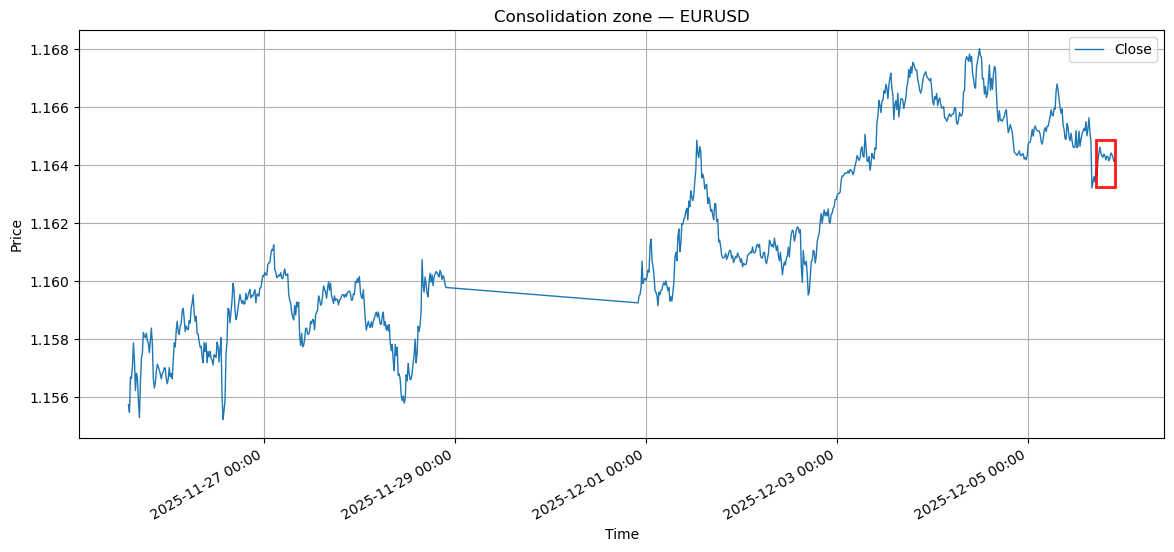

Consolidation detected for GBPUSD:
  start_time: 2025-12-05 00:45:00, end_time: 2025-12-05 05:30:00
  low_level: 1.332500, high_level: 1.334490


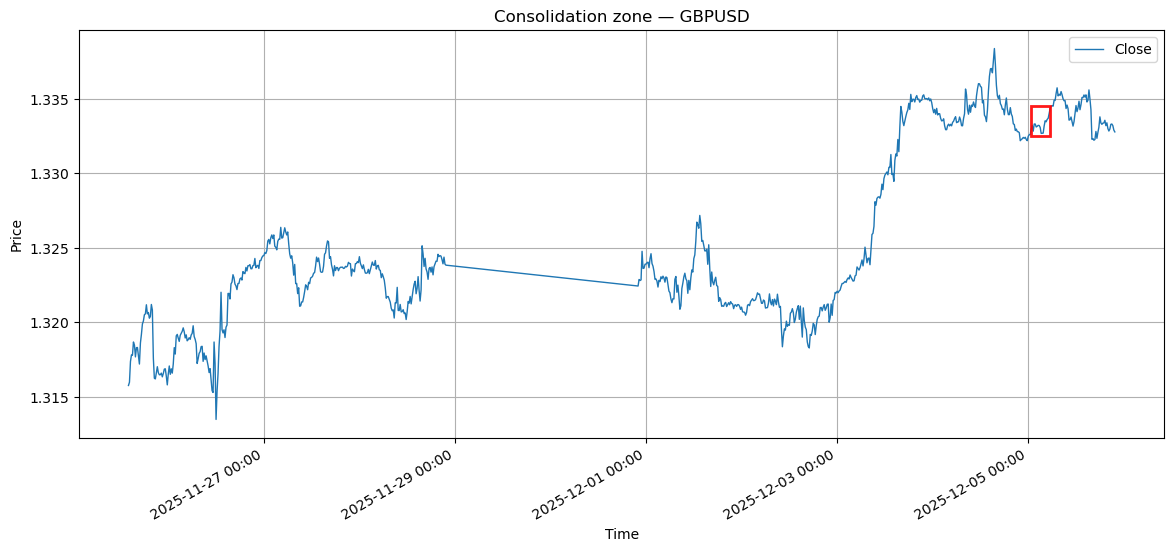

No consolidation detected for XAUUSD (window=20, threshold_pips=20).


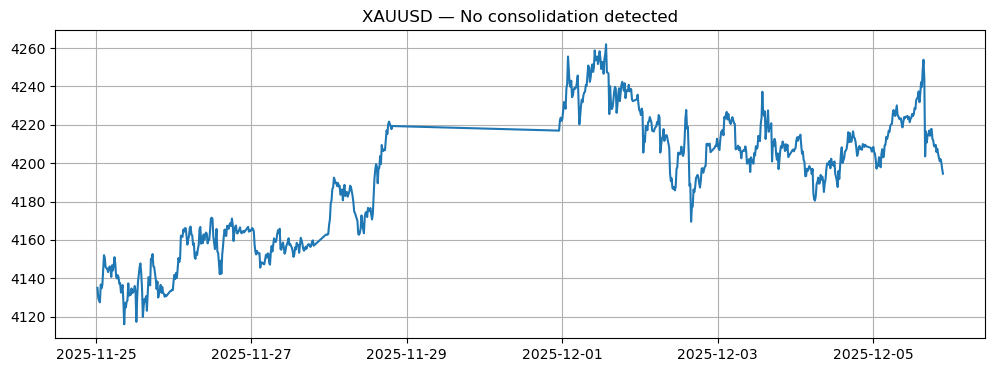

No consolidation detected for Volatility 10 Index (window=20, threshold_pips=20).


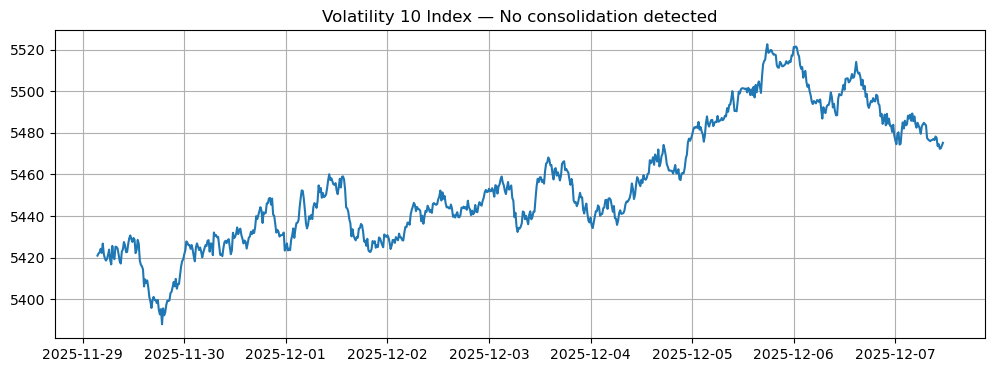

No consolidation detected for Volatility 25 Index (window=20, threshold_pips=20).


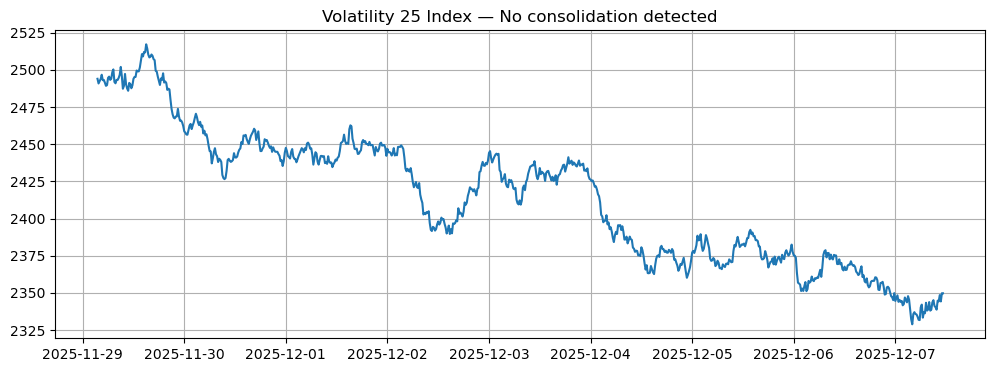

No consolidation detected for Volatility 50 Index (window=20, threshold_pips=20).


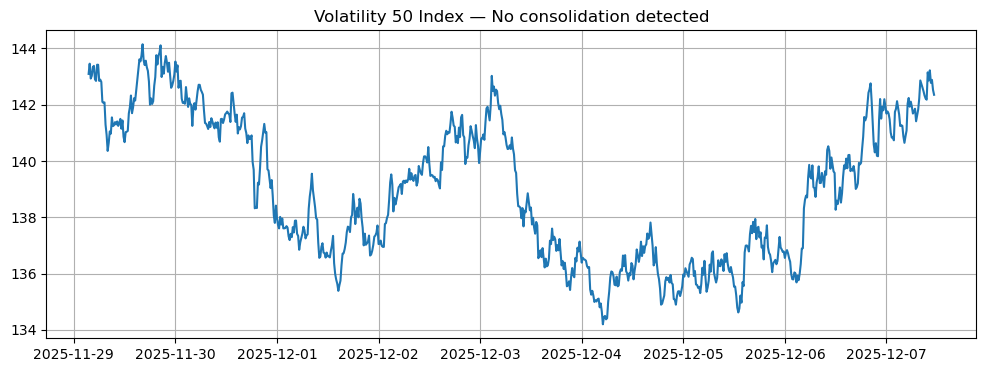

No consolidation detected for Volatility 75 Index (window=20, threshold_pips=20).


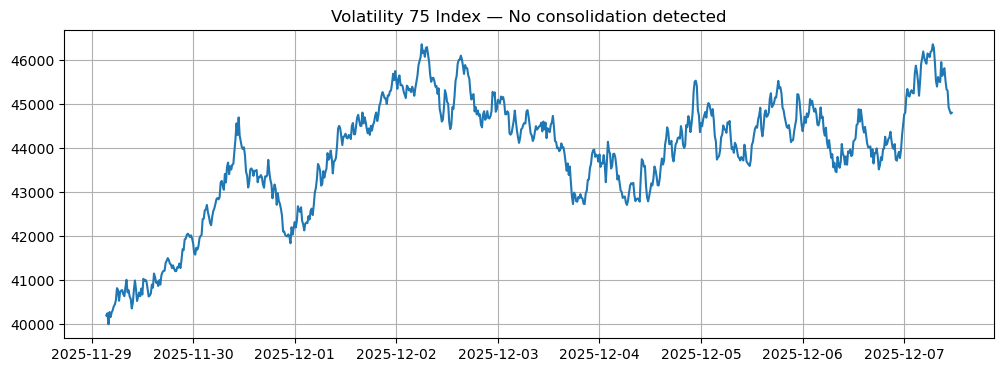

No consolidation detected for Volatility 100 Index (window=20, threshold_pips=20).


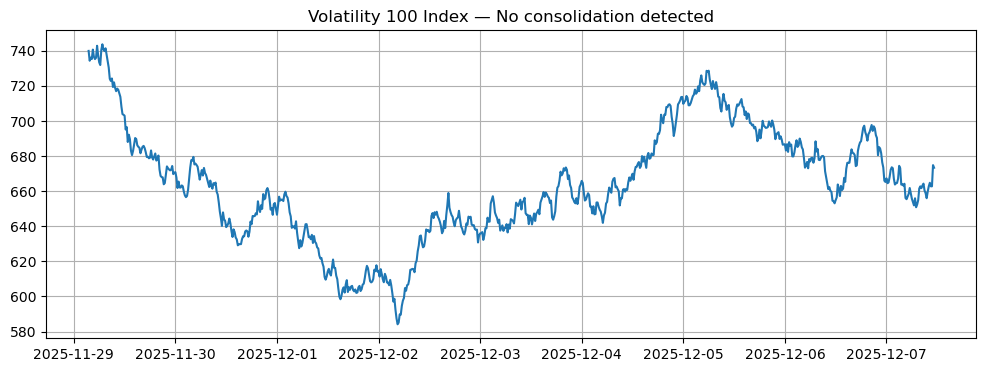

No consolidation detected for Volatility 10 (1s) Index (window=20, threshold_pips=20).


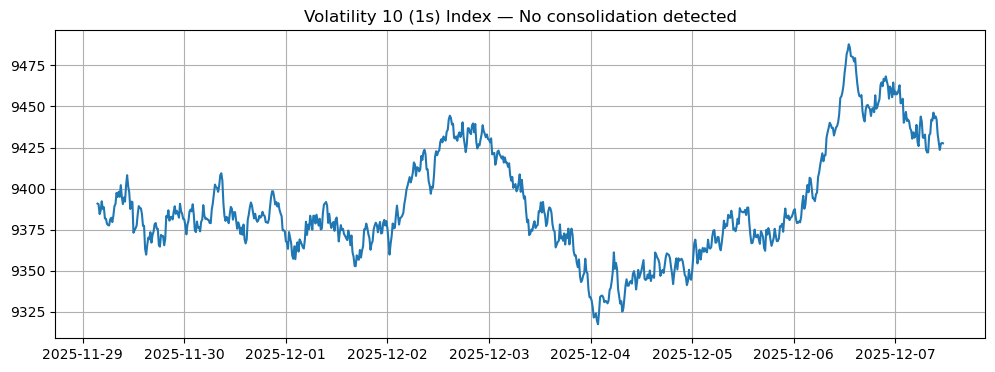

No consolidation detected for Volatility 25 (1s) Index (window=20, threshold_pips=20).


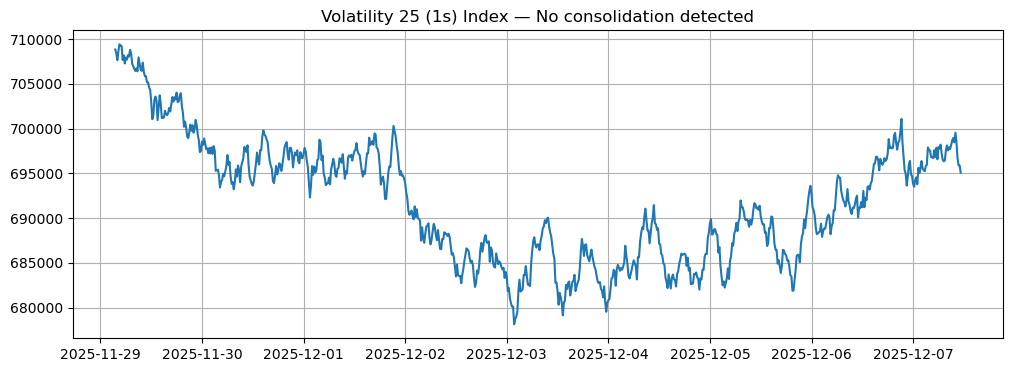

No consolidation detected for Volatility 50 (1s) Index (window=20, threshold_pips=20).


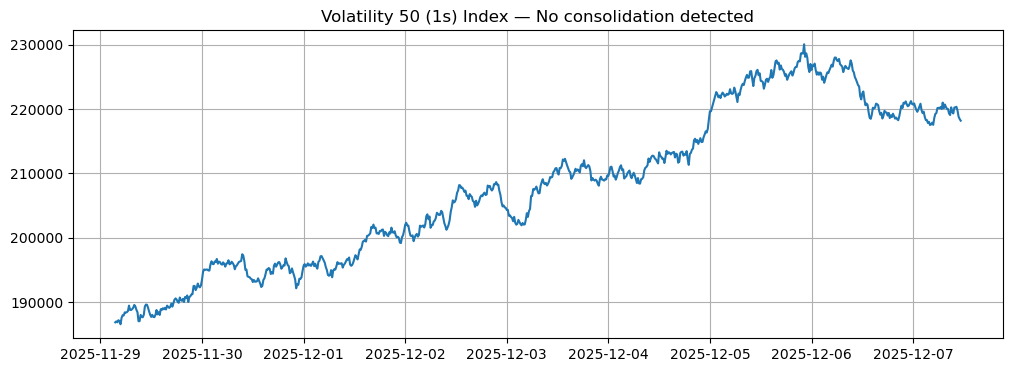

No consolidation detected for Volatility 75 (1s) Index (window=20, threshold_pips=20).


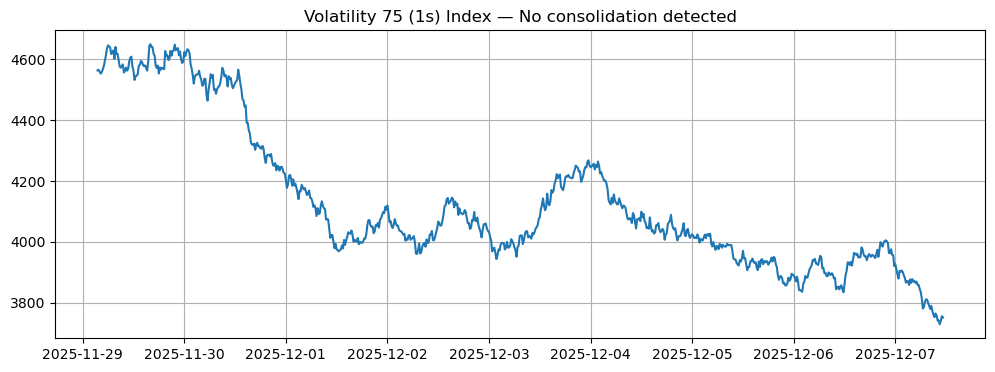

No consolidation detected for Volatility 100 (1s) Index (window=20, threshold_pips=20).


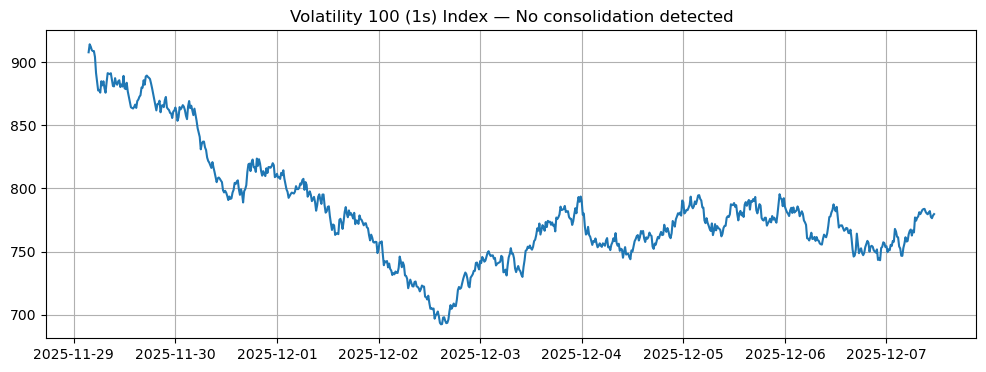

No consolidation detected for Volatility 50 (1s) Index (window=20, threshold_pips=20).


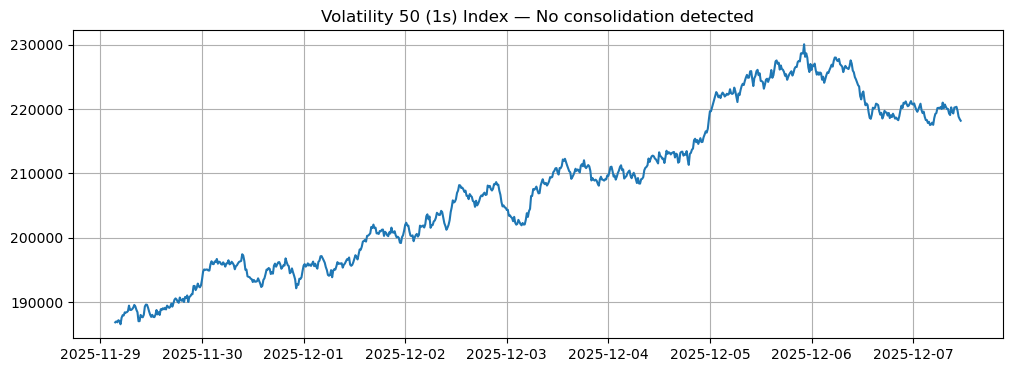

No consolidation detected for Jump 10 Index (window=20, threshold_pips=20).


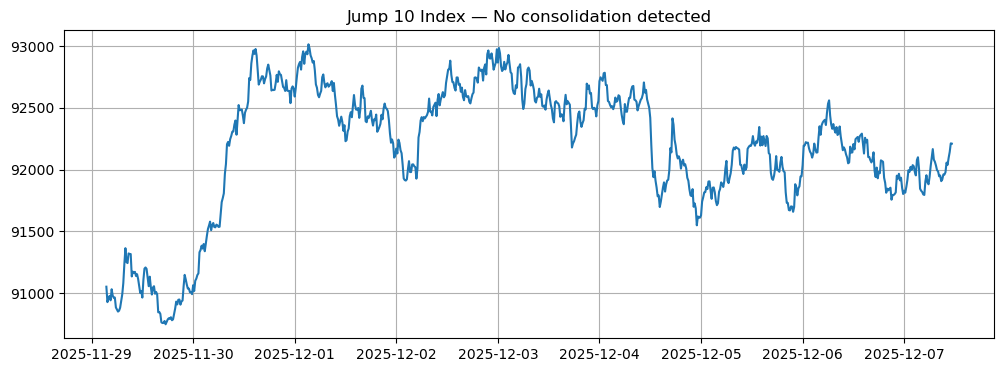

No consolidation detected for Jump 25 Index (window=20, threshold_pips=20).


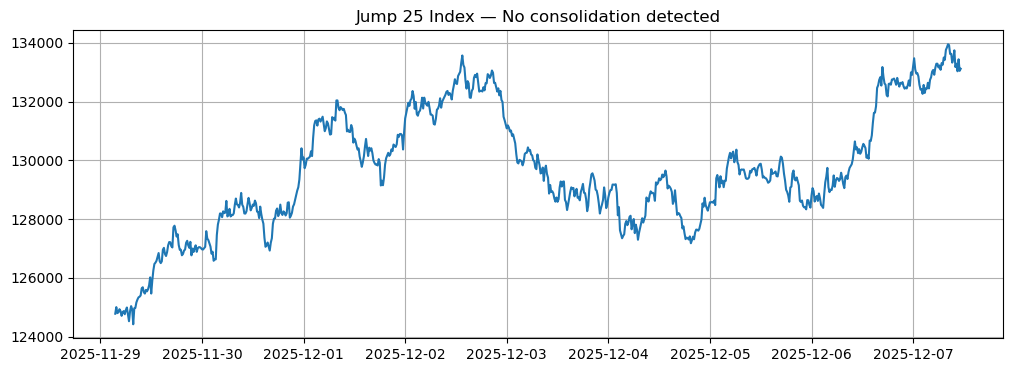

No consolidation detected for Jump 50 Index (window=20, threshold_pips=20).


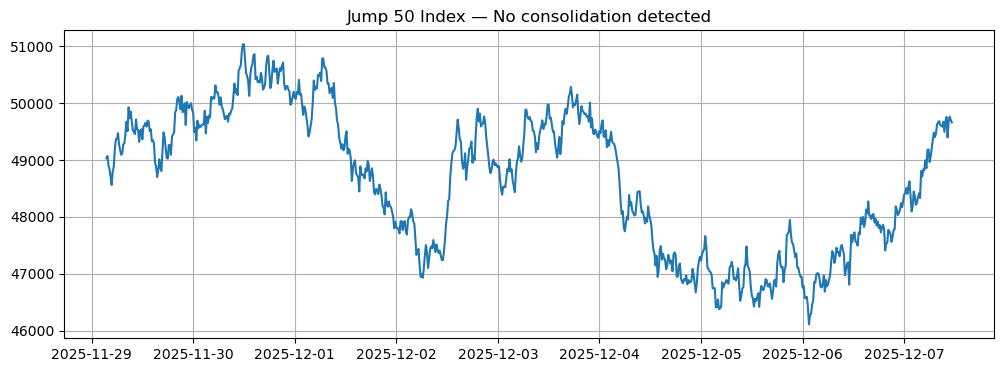

No consolidation detected for Jump 75 Index (window=20, threshold_pips=20).


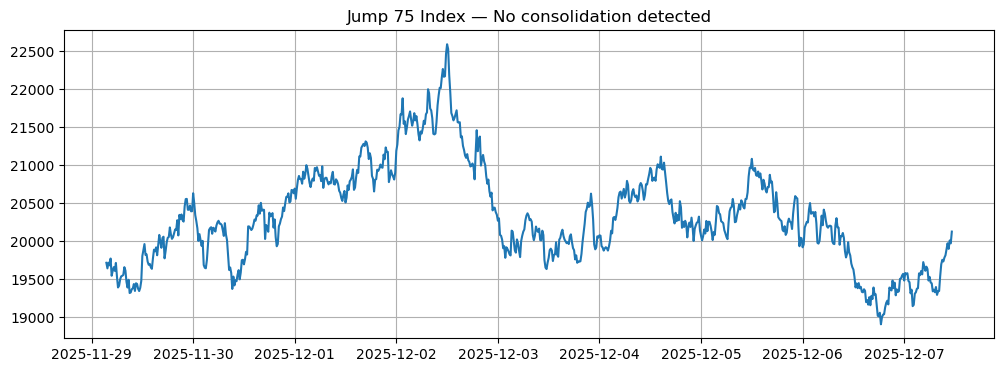

No consolidation detected for Jump 100 Index (window=20, threshold_pips=20).


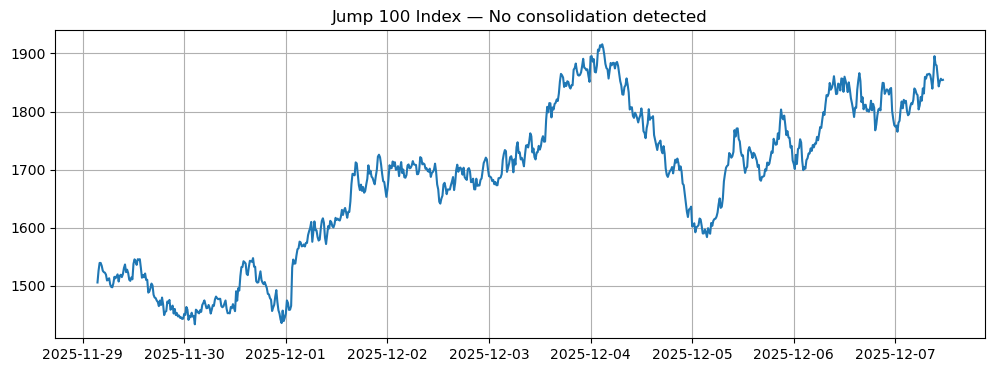


Summary (1 = consolidation detected): {'EURUSD': 1, 'GBPUSD': 1, 'XAUUSD': 0, 'Volatility 10 Index': 0, 'Volatility 25 Index': 0, 'Volatility 50 Index': 0, 'Volatility 75 Index': 0, 'Volatility 100 Index': 0, 'Volatility 10 (1s) Index': 0, 'Volatility 25 (1s) Index': 0, 'Volatility 50 (1s) Index': 0, 'Volatility 75 (1s) Index': 0, 'Volatility 100 (1s) Index': 0, 'Jump 10 Index': 0, 'Jump 25 Index': 0, 'Jump 50 Index': 0, 'Jump 75 Index': 0, 'Jump 100 Index': 0}


In [67]:
# Single Jupyter cell — detect consolidation and draw rectangle (MT5 required)
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# ---------- Configurable parameters ----------
TIMEFRAME = mt5.TIMEFRAME_M15   # change if needed
BARS = 800                      # how many recent bars to fetch
WINDOW = 20                     # rolling window to judge consolidation
THRESHOLD_PIPS = 20             # consolidation if (high-low) < threshold_pips
# ----------------------------------------------

def pip_value_for_symbol(symbol):
    info = mt5.symbol_info(symbol)
    if info is None:
        # default pip for forex-like pairs
        return 0.0001
    try:
        # MT5 'point' is the minimal price step. Commonly pip=point*10 for 5-digit quoting.
        digits = int(info.digits)
        if digits in (3, 5):
            return float(info.point) * 10.0
        else:
            return float(info.point)
    except Exception:
        return float(getattr(info, "point", 0.0001))

def fetch_bars(symbol, timeframe=TIMEFRAME, bars=BARS):
    """Fetch bars from MT5 and return pandas DataFrame with time as datetime index."""
    if not mt5.initialize():
        raise RuntimeError("MT5 not initialized — start the MT5 terminal and login.")
    rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, bars)
    if rates is None or len(rates) == 0:
        return None
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    # normalize column names and ensure volume
    if 'tick_volume' in df.columns and 'volume' not in df.columns:
        df = df.rename(columns={'tick_volume': 'volume'})
    return df[['open','high','low','close','volume']].copy()

def find_most_recent_consolidation(df, window=WINDOW, threshold_pips=THRESHOLD_PIPS, symbol=None):
    """
    Find the most recent index (end) where rolling (max high - min low) < threshold (in price units).
    Returns tuple: (found_flag, start_time, end_time, low_level, high_level)
    """
    if df is None or len(df) < window + 1:
        return 0, None, None, None, None

    if symbol is None:
        raise ValueError("symbol must be provided to compute pip size")
    pip = pip_value_for_symbol(symbol)
    price_threshold = threshold_pips * pip

    rolling_high = df['high'].rolling(window=window).max()
    rolling_low  = df['low'].rolling(window=window).min()
    rolling_range = rolling_high - rolling_low

    # boolean series marking consolidation windows
    is_cons = rolling_range < price_threshold

    # find last True (most recent consolidation)
    true_idx = np.where(is_cons.values)[0]
    if len(true_idx) == 0:
        return 0, None, None, None, None

    end_pos = true_idx[-1]                     # integer position (0-based)
    # ensure we can compute start_pos safely
    start_pos = max(0, end_pos - (window - 1))

    # get timestamps and levels
    start_time = rolling_range.index[start_pos]
    end_time = rolling_range.index[end_pos]
    low_level = float(rolling_low.iloc[end_pos])
    high_level = float(rolling_high.iloc[end_pos])

    return 1, start_time, end_time, low_level, high_level

def plot_with_consolidation(symbol, df, start_time, end_time, low_level, high_level, ax=None):
    """
    Plot close price and draw a rectangle for the consolidation zone (time-price rectangle).
    Uses matplotlib.dates conversion for correct alignment.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(14,6))
    else:
        fig = ax.figure

    # plot close
    ax.plot(df.index, df['close'], label='Close', linewidth=1.0)

    # prepare rectangle corners in date numbers
    start_num = mdates.date2num(pd.to_datetime(start_time).to_pydatetime())
    end_num   = mdates.date2num(pd.to_datetime(end_time).to_pydatetime())
    width = end_num - start_num
    height = high_level - low_level

    # If width is 0 (rare), expand slightly to make rectangle visible
    if width <= 0:
        width = 0.0001

    # add rectangle
    rect = plt.Rectangle(
        (start_num, low_level),
        width,
        height,
        linewidth=2,
        edgecolor='red',
        facecolor='none',
        alpha=0.9,
        zorder=3
    )
    ax.add_patch(rect)

    # nice formatting
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.set_title(f"Consolidation zone — {symbol}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price")
    ax.grid(True)
    ax.legend()
    fig.autofmt_xdate()
    plt.show()

def detect_and_plot_consolidation(symbol, timeframe=TIMEFRAME, bars=BARS, window=WINDOW, threshold_pips=THRESHOLD_PIPS):
    """
    Fetch bars for `symbol`, detect most recent consolidation window, draw rectangle if found.
    Returns 1 if consolidation found, otherwise 0.
    """
    df = fetch_bars(symbol, timeframe=timeframe, bars=bars)
    if df is None or df.empty:
        print(f"Failed to fetch bars for {symbol}.")
        return 0

    found, start_time, end_time, low_level, high_level = find_most_recent_consolidation(
        df, window=window, threshold_pips=threshold_pips, symbol=symbol
    )

    if found == 0:
        print(f"No consolidation detected for {symbol} (window={window}, threshold_pips={threshold_pips}).")
        # show price plot anyway
        fig, ax = plt.subplots(figsize=(12,4))
        ax.plot(df.index, df['close'], label='Close')
        ax.set_title(f"{symbol} — No consolidation detected")
        ax.grid(True)
        plt.show()
        return 0

    print(f"Consolidation detected for {symbol}:")
    print(f"  start_time: {start_time}, end_time: {end_time}")
    print(f"  low_level: {low_level:.6f}, high_level: {high_level:.6f}")

    # plot with rectangle
    plot_with_consolidation(symbol, df, start_time, end_time, low_level, high_level)
    return 1

# ---------------- Example usage ----------------
# Put your desired symbol(s) below. MT5 terminal must be running and logged in.

symbols_to_check = ["EURUSD", "GBPUSD", "XAUUSD", "Volatility 10 Index","Volatility 25 Index","Volatility 50 Index","Volatility 75 Index","Volatility 100 Index",
    "Volatility 10 (1s) Index","Volatility 25 (1s) Index","Volatility 50 (1s) Index","Volatility 75 (1s) Index","Volatility 100 (1s) Index",
    "Volatility 50 (1s) Index", "Jump 10 Index","Jump 25 Index","Jump 50 Index","Jump 75 Index","Jump 100 Index"]  # change as needed

results = {}
for s in symbols_to_check:
    try:
        res = detect_and_plot_consolidation(s, timeframe=TIMEFRAME, bars=BARS, window=WINDOW, threshold_pips=THRESHOLD_PIPS)
        results[s] = res
    except Exception as e:
        print("Error for", s, ":", e)
        results[s] = 0

print("\nSummary (1 = consolidation detected):", results)


In [31]:
#NEW
def run_once_predict_and_manage(symbols_list):
    mt5_connect()
    acct = mt5.account_info()
    balance = float(acct.balance) if acct is not None else 10000.0

    header = not os.path.exists(LOG_FILE)

    for mt5_symbol in symbols_list:
        print(f"\n--- {mt5_symbol} ---")

        # Build observation
        obs_tuple = build_obs_for_symbol(mt5_symbol, WINDOW)
        if obs_tuple is None or obs_tuple[0] is None:
            print("No observation for", mt5_symbol)
            continue

        obs, vol, last_price = obs_tuple

        # Predict
        try:
            action, _ = model.predict(obs[np.newaxis, ...], deterministic=True)
            a = int(action[0]) if isinstance(action, (list, tuple, np.ndarray)) else int(action)
        except Exception as e:
            print("Prediction error:", e)
            continue

        print("Signal:", a, "(0=HOLD,1=BUY,2=SELL)")

        # Check existing positions
        positions = get_positions_for_symbol(mt5_symbol)
        print("Existing positions:", len(positions))

        #################################################
        # Auto-close opposing positions
        #################################################
        if a == 1:  # BUY signal => close SELL
            for p in positions:
                if getattr(p, "type", None) == 1:
                    print("Closing opposing SELL ticket", p.ticket)
                    close_position_by_ticket(p.ticket)

        elif a == 2:  # SELL signal => close BUY
            for p in positions:
                if getattr(p, "type", None) == 0:
                    print("Closing opposing BUY ticket", p.ticket)
                    close_position_by_ticket(p.ticket)

        # Refresh position list
        positions = get_positions_for_symbol(mt5_symbol)

        #################################################
        # Trade Execution
        #################################################
        if len(positions) >= MAX_POS_PER_SYMBOL:
            print("Max positions reached for", mt5_symbol)

        else:
            if a == 0:
                print("HOLD")
            else:
                direction = "BUY" if a == 1 else "SELL"
                lot = DEFAULT_LOT

                # SL estimation
                sl_pips = estimate_sl_pips(mt5_symbol, last_price, vol)
                tp_pips = int(sl_pips * TP_MULT)

                sl_price, tp_price = compute_sl_tp_prices(
                    mt5_symbol, last_price, direction, sl_pips, tp_pips
                )

                # Execute trade
                res = place_market_order(mt5_symbol, direction, lot, sl_price, tp_price)

                if isinstance(res, dict):
                    retcode = res.get("retcode")
                    comment = res.get("comment")
                    exec_price = res.get("price", last_price)
                else:
                    retcode = getattr(res, "retcode", None)
                    comment = getattr(res, "comment", "")
                    exec_price = last_price

                # Log trade
                entry = {
                    "timestamp": datetime.utcnow().isoformat(),
                    "symbol": mt5_symbol,
                    "action": direction,
                    "lot": lot,
                    "exec_price": exec_price,
                    "sl_price": sl_price,
                    "tp_price": tp_price,
                    "sl_pips": sl_pips,
                    "tp_pips": tp_pips,
                    "retcode": retcode,
                    "comment": comment,
                    "dry_run": DRY_RUN
                }
                pd.DataFrame([entry]).to_csv(
                    LOG_FILE, mode="a", index=False, header=header
                )
                header = False
                print("Placed", direction, "lot", lot, "retcode", retcode)

        #################################################
        # Trailing Stop Engine
        #################################################
        for p in get_positions_for_symbol(mt5_symbol):

            trail_pips = max(5, int(estimate_sl_pips(mt5_symbol, last_price, vol) // 2))
            pip = pip_value(mt5_symbol)

            if getattr(p, "type", None) == 0:  # BUY
                cur_price = mt5.symbol_info_tick(mt5_symbol).bid
                new_sl = float(cur_price - trail_pips * pip)
            else:  # SELL
                cur_price = mt5.symbol_info_tick(mt5_symbol).ask
                new_sl = float(cur_price + trail_pips * pip)

            if DRY_RUN:
                print(f"[DRY] Would set trailing SL for ticket {p.ticket} -> {new_sl}")
            else:
                req = {
                    "action": mt5.TRADE_ACTION_SLTP,
                    "symbol": mt5_symbol,
                    "position": int(p.ticket),
                    "sl": new_sl,
                    "tp": float(p.tp) if getattr(p, "tp", None) else 0.0
                }
                r = mt5.order_send(req)
                print("Modify SL result:", getattr(r, "retcode", None))

    mt5_shutdown()
    print("\nSingle pass complete.")


In [24]:
# Calculate Optimum Lot-size
def calculate_optimal_volume(symbol: str, entry_price: float, sl_price: float, risk_percent: float) -> float:
    """
    Calculates the optimal lot size based on account equity, risk percentage,
    and the stop loss distance, constrained by symbol limits.

    The formula is: OptimalLotSize = (Equity * RiskPercentage) / (abs(EntryPrice - SLPrice) * ContractSize)
    """
    
    # 1. Get Account Equity
    account_info = mt5.account_info()
    if account_info is None:
        print("Error: Could not retrieve account information.")
        return 0.0
    acc_equity = account_info.balance
    
    # 2. Get Symbol Information for contract size and volume limits
    symbol_info = mt5.symbol_info(symbol)
    if symbol_info is None:
        print(f"Error: Could not retrieve symbol info for {symbol}.")
        return 0.0
    
    contract_size = symbol_info.trade_contract_size
    min_volume = symbol_info.volume_min
    max_volume = symbol_info.volume_max
    volume_step = symbol_info.volume_step
    
    # Check for zero values to prevent division by zero
    if contract_size == 0:
        print(f"Error: Contract size is zero for {symbol}. Returning minimum volume.")
        return min_volume
        
    # 3. Calculate Maximum Dollar Loss
    max_loss_dollar = acc_equity * risk_percent
    
    # 4. Calculate Loss per Lot (Loss in price difference * Contract Size)
    price_loss = abs(entry_price - sl_price)
    
    # If SL is too close or equal to entry, use min volume as a fallback.
    if price_loss == 0.0:
        print(f"Warning: SL is equal to entry price for {symbol}. Using minimum volume.")
        return min_volume

    loss_per_lot = price_loss * contract_size
    
    # 5. Calculate Optimal Lot Size (Theoretical)
    optimal_lot_size = max_loss_dollar / loss_per_lot
    
    # 6. Apply Volume Step and Min/Max constraints
    
    # Snap the calculated lot size to the nearest allowed volume step (e.g., 0.01)
    optimal_lot_size = round(optimal_lot_size / volume_step) * volume_step
    
    # Apply min/max volume limits
    final_volume = max(min_volume, min(max_volume, optimal_lot_size))
        
    print(f"  [Risk Calcs] Equity: {acc_equity:.2f}, Risk %: {risk_percent*100}%, Max Loss $: {max_loss_dollar:.2f}, Final Volume: {final_volume:.2f}")
    
    # Ensure the final volume is rounded to the step size's precision
    final_volume = round(final_volume, len(str(volume_step).split('.')[-1]) if '.' in str(volume_step) else 0)

    return final_volume


In [53]:
def get_symbol_info(symbol: str): #BEST
    """
    Retrieves and prepares the symbol for trading.
    Returns the symbol information object and the price tick value.
    """
    symbol_info = mt5.symbol_info(symbol)
    if symbol_info is None:
        print(f"--- {symbol} NOT FOUND ---")
        return None, None

    if not symbol_info.visible:
        # Check if the symbol can be added to Market Watch
        if not mt5.symbol_select(symbol, True):
            print(f"--- {symbol} NOT TRADABLE: Not visible and could not be added ---")
            return None, None

    # Get the tick size (point value) for SL/TP calculations
    pip_value = symbol_info.point
    
    tick = mt5.symbol_info_tick(symbol)
    if tick is None:
        print(f"--- {symbol} NOT TRADABLE: Could not get tick info ---")
        return None, None
        
    print(f"\n--- Symbol Ready: {symbol} ---")
    print(f"Digits: {symbol_info.digits} | Point: {symbol_info.point} | Bid: {tick.bid} | Ask: {tick.ask}")
    
    return symbol_info, pip_value


In [57]:
 # This one works well to place trades and calculates optimum the lot-size #BEST
# --- Place trades ---
def place_market_order(symbol_info, pip_value: float, order_type: int):
    """
    Constructs and sends a market order (BUY or SELL) using a dynamically calculated volume.
    
    :param symbol_info: mt5.symbol_info object
    :param pip_value: The size of a single pip (point) for the symbol
    :param order_type: mt5.ORDER_TYPE_BUY or mt5.ORDER_TYPE_SELL
    """
    symbol = symbol_info.name
    
    # Get current price
    tick = mt5.symbol_info_tick(symbol)
    if tick is None:
        print(f"Failed to get current tick for {symbol}.")
        # Return a dictionary indicating local failure before calling format_result
        return None, {"symbol": symbol, "type": order_type, "volume": 0.0} 

    # Determine execution price, trade type, and SL/TP prices
    if order_type == mt5.ORDER_TYPE_BUY:
        price = tick.ask
        type_text = "BUY"
        # SL/TP calculation (SL below, TP above entry price for BUY)
        sl_price = price - (SL_OFFSET_PIPS * pip_value)
        tp_price = price + (TP_OFFSET_PIPS * pip_value)
    elif order_type == mt5.ORDER_TYPE_SELL:
        price = tick.bid
        type_text = "SELL"
        # SL/TP calculation (SL above, TP below entry price for SELL)
        sl_price = price + (SL_OFFSET_PIPS * pip_value)
        tp_price = price - (TP_OFFSET_PIPS * pip_value)
    else:
        print("Invalid order type.")
        return None, None
        
    # --- DYNAMIC VOLUME CALCULATION ---
    volume_to_use = calculate_optimal_volume(
        symbol, 
        price, 
        sl_price, 
        RISK_PERCENTAGE
    )
    
    if volume_to_use <= 0.0:
        print(f"Skipping trade for {symbol}: Calculated volume is zero or negative.")
        # Return the request dictionary with 0 volume to be logged as a skipped trade
        return None, {"symbol": symbol, "type": order_type, "volume": 0.0}

    # Prepare the request dictionary
    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": volume_to_use, # <-- Dynamic volume used here
        "type": order_type,
        "price": price,
        # Round SL/TP based on the symbol's number of digits
        "sl": round(sl_price, symbol_info.digits), 
        "tp": round(tp_price, symbol_info.digits), 
        "deviation": DEVIATION,
        "magic": MAGIC,
        "comment": COMMENT,
        "type_time": mt5.ORDER_TIME_GTC, 
        "type_filling": mt5.ORDER_FILLING_FOK, 
    }

    # Send order to MT5
    print(f"  Sending {type_text} order for {symbol} with {volume_to_use:.2f} lots at {price:.{symbol_info.digits}f}...")
    result = mt5.order_send(request)

    return result, request






In [60]:
def format_result(result, request): #BEST
    """
    Formats the order result and request into a clean dictionary.
    Handles both successful and failed execution attempts.
    """
    symbol = request.get("symbol", "N/A")
    symbol_info = mt5.symbol_info(symbol) if symbol != "N/A" else None
    digits = symbol_info.digits if symbol_info else 4 # Default to 4 digits for formatting
    
    # --- Local Failure Handling (e.g., failed tick check in place_market_order) ---
    if result is None:
        comment_text = request.get("comment", "Local error: Tick or price info failed.")
        if request.get("volume") == 0.0:
            comment_text = "Trade skipped: Volume calculated as zero."
            
        return {
            "Time": datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'),
            "Status": "SKIPPED/FAILED (Local)",
            "Return Code": "N/A",
            "Comment": comment_text,
            "Symbol": symbol,
            "Type": "BUY" if request.get("type") == mt5.ORDER_TYPE_BUY else "SELL",
            "Volume": request.get("volume", "N/A"),
            "Price": "N/A",
            "SL": "N/A",
            "TP": "N/A",
            "Order Ticket": "N/A",
            "Deal Ticket": "N/A",
            "Position Ticket": "N/A",
        }
        
    # --- MT5 Result Handling ---
    # Implement a robust check for time attributes
    timestamp = time.time() # Default to local time
    if hasattr(result, 'time') and result.time > 0:
        timestamp = result.time
    elif hasattr(result, 'time_done') and result.time_done > 0:
        timestamp = result.time_done
        
    # Create the output dictionary
    output = {
        "Time": datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S'),
        "Status": "SUCCESS" if result.retcode == mt5.TRADE_RETCODE_DONE else "FAILURE",
        "Return Code": result.retcode,
        "Comment": result.comment,
        "Symbol": symbol,
        "Type": "BUY" if request.get("type") == mt5.ORDER_TYPE_BUY else "SELL",
        "Volume": request.get("volume"),
        # Format prices using the symbol's digits
        "Price": f"{result.price:.{digits}f}",
        "SL": f"{request.get('sl'):.{digits}f}",
        "TP": f"{request.get('tp'):.{digits}f}",
        "Order Ticket": result.order,
        "Deal Ticket": result.deal,
        "Position Ticket": result.position if hasattr(result, 'position') else "N/A",
    }
    
    return output


In [61]:
# ==============================================================================
# --- MAIN EXECUTION LOGIC --- BEST
# ==============================================================================

def main():
    """Executes the trade bot logic."""
    if mt5_connect():
        
        print("\nStarting multi-symbol trade execution...")
        
        #for symbol_name in SYMBOL_LIST:
        for symbol_name in SYMBOLS:
            # 1. Get Symbol Information
            symbol_info, pip_value = get_symbol_info(symbol_name)
            
            if symbol_info and pip_value:
                # --- PLACE A BUY ORDER ---
                # Note: The 'volume' parameter is omitted here as it's calculated dynamically inside the function.
                trade_result, trade_request = place_market_order(
                    symbol_info, 
                    pip_value, 
                    mt5.ORDER_TYPE_BUY
                
                )
                
                # 2. Collect the result
                # We check for trade_request to ensure an attempt was made, even if it failed locally
                if trade_request:
                    ALL_TRADE_RESULTS.append(format_result(trade_result, trade_request))
            
            # Add a small delay between trades to respect broker limits
            time.sleep(0.5)

        # 3. Display all results in a single, aggregated DataFrame
        if ALL_TRADE_RESULTS:
            final_df = pd.DataFrame(ALL_TRADE_RESULTS)
            print("\n" + "="*100)
            print("--- AGGREGATED MULTI-SYMBOL TRADE EXECUTION RESULTS (BUY Orders) ---")
            print("="*100)
            # Use max_rows=None to ensure all records are displayed
            pd.set_option('display.max_rows', None) 
            print(final_df.to_string(index=False))
            
        # 4. Shutdown MT5 connection
        mt5.shutdown()
        print("\nMT5 connection successfully shut down.")


if __name__ == "__main__":
    main()

MT5 connected. Version: (500, 5430, '14 Nov 2025')

Starting multi-symbol trade execution...

--- Symbol Ready: Volatility 10 Index ---
Digits: 3 | Point: 0.001 | Bid: 5442.38 | Ask: 5442.531
  [Risk Calcs] Equity: 5989.00, Risk %: 2.0%, Max Loss $: 119.78, Final Volume: 11.98
  Sending BUY order for Volatility 10 Index with 11.98 lots at 5442.531...

--- Symbol Ready: Volatility 25 Index ---
Digits: 3 | Point: 0.001 | Bid: 2402.411 | Ask: 2402.58
  [Risk Calcs] Equity: 5989.00, Risk %: 2.0%, Max Loss $: 119.78, Final Volume: 11.98
  Sending BUY order for Volatility 25 Index with 11.98 lots at 2402.580...

--- Symbol Ready: Volatility 50 Index ---
Digits: 4 | Point: 0.0001 | Bid: 139.8393 | Ask: 139.8583
  [Risk Calcs] Equity: 5989.00, Risk %: 2.0%, Max Loss $: 119.78, Final Volume: 119.78
  Sending BUY order for Volatility 50 Index with 119.78 lots at 139.8583...

--- Symbol Ready: Volatility 75 Index ---
Digits: 2 | Point: 0.01 | Bid: 45281.53 | Ask: 45293.61
  [Risk Calcs] Equity: 5